# EDA on text data
## Import necessary libraries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [6]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [7]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [8]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load preprocessed data

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [195]:
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

In [196]:
def load_finphrase(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    df = pd.read_csv(finphrase_dir + filename,
                     sep='\@',
                     engine='python',
                     header=None,
                     names=['sentence','label'])
    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)
    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)
    # df = pd.get_dummies(df, columns=['label'])
    return df

def convert_label(x):
    if x == 'positive':
        return 2
    elif x == 'neutral':
        return 1
    elif x == 'negative':
        return 0

In [197]:
# Load data
filename = 'Sentences_66Agree.txt'
# filename = 'Sentences_50Agree.txt'
# filename = 'Sentences_75Agree.txt'
# filename = 'Sentences_AllAgree.txt'

train_df = load_finphrase(filename)
train_df

Total number of record in the file:  4217
Total number of record after dropping duplicates:  4211
Missing label:  0


sentence     label
0     According to Gran , the company has no plans t...   neutral
1     Technopolis plans to develop in stages an area...   neutral
2     With the new production plant the company woul...  positive
3     According to the company 's updated strategy f...  positive
4     For the last quarter of 2010 , Componenta 's n...  positive
...                                                 ...       ...
4206  HELSINKI Thomson Financial - Shares in Cargote...  negative
4207  LONDON MarketWatch -- Share prices ended lower...  negative
4208  Rinkuskiai 's beer sales fell by 6.5 per cent ...   neutral
4209  Operating profit fell to EUR 35.4 mn from EUR ...  negative
4210  Sales in Finland decreased by 10.5 % in Januar...  negative

[4211 rows x 2 columns]

## Check the statistics of texts

Text(0.5, 1.0, 'The number of words per data')

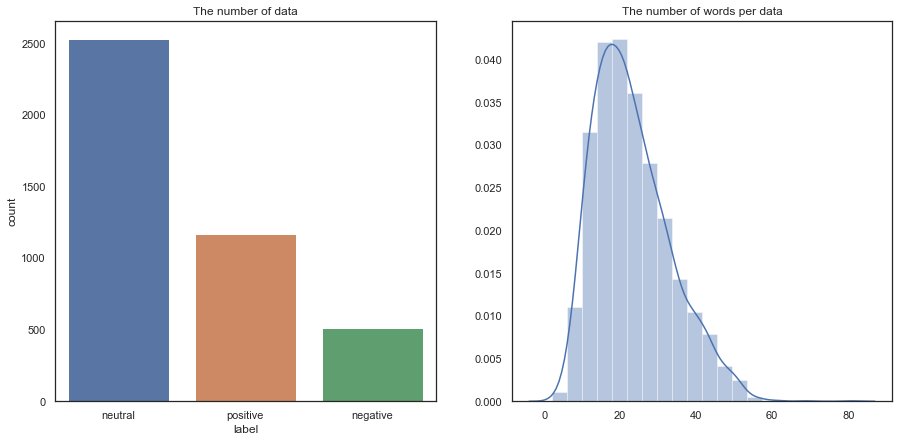

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data')
sns.distplot([len(nltk.word_tokenize(words)) for words in train_df['sentence']], bins=20, ax=ax2)
ax2.set_title('The number of words per data')

The label is imbalanced and thus better to consider the measurement or balancing the data.

## Explore the text

In [37]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [38]:
corpus = create_corpus(train_df)

In [39]:
x, y = get_frequent_stop_words(corpus)

In [40]:
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'is', 'will', 'from')
(5269, 2821, 2571, 2216, 2162, 1472, 1009, 783, 723, 710)


In [41]:
x, y = get_frequent_nonstop_words(corpus)

In [42]:
print(x)
print(y)

('.', ',', 'eur', "'s", 'company', 'mn', ')', '(', 'said', 'finnish')
(4149, 4017, 973, 857, 715, 509, 450, 448, 447, 438)


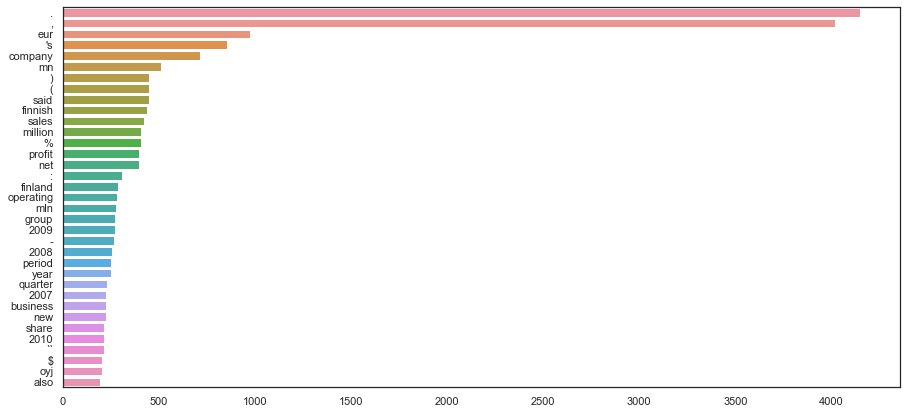

In [43]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

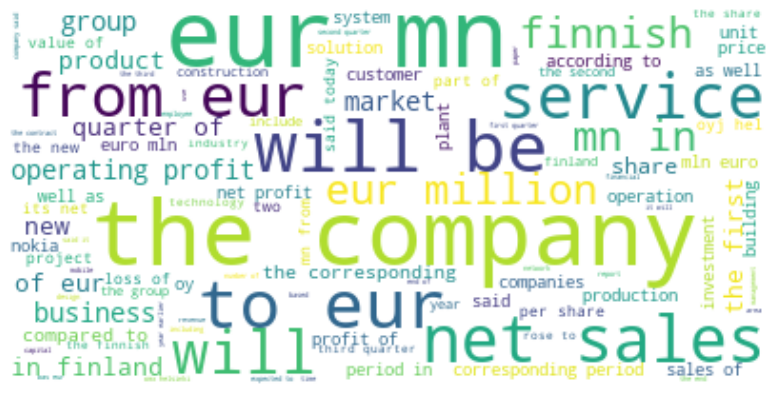

In [44]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [47]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


sentiment            word
0         Negative         ABANDON
1         Negative       ABANDONED
2         Negative      ABANDONING
3         Negative     ABANDONMENT
4         Negative    ABANDONMENTS
...            ...             ...
4135  Constraining        STRICTER
4136  Constraining       STRICTEST
4137  Constraining        STRICTLY
4138  Constraining  UNAVAILABILITY
4139  Constraining     UNAVAILABLE

[4140 rows x 2 columns]

In [48]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   184
Litigious      904
Negative      2355
Positive       354
StrongModal     19
Uncertainty    297
WeakModal       27

In [49]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [50]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [57]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df


(4211, 2)


sentence     label  tone_score  \
0     According to Gran , the company has no plans t...   neutral    0.000000   
1     Technopolis plans to develop in stages an area...   neutral    0.000000   
2     With the new production plant the company woul...  positive    6.250000   
3     According to the company 's updated strategy f...  positive    0.000000   
4     For the last quarter of 2010 , Componenta 's n...  positive   -2.941176   
...                                                 ...       ...         ...   
4206  HELSINKI Thomson Financial - Shares in Cargote...  negative   -5.263158   
4207  LONDON MarketWatch -- Share prices ended lower...  negative   -4.347826   
4208  Rinkuskiai 's beer sales fell by 6.5 per cent ...   neutral    0.000000   
4209  Operating profit fell to EUR 35.4 mn from EUR ...  negative    5.882353   
4210  Sales in Finland decreased by 10.5 % in Januar...  negative   -7.692308   

      word_count  n_pos_words  n_neg_words                 pos_words  \
0             22            0            0                        []   
1             28            0            0                        []   
2             32            2            0  [improve, profitability]   
3             31            0            0                        []   
4             34            0            1                        []   
...          ...          ...          ...                       ...   
4206          38            0            2                        []   
4207          23            1            2                 [rebound]   
4208          23            0            0                        []   
4209          17            1            0                    [gain]   
4210          13            0            1                        []   

                    neg_words  
0                          []  
1                          []  
2                          []  
3                          []  
4                      [loss]  
...                       ...  
4206  [sharply, overshadowed]  
4207       [failed, weakness]  
4208                       []  
4209                       []  
4210                [dropped]  

[4211 rows x 8 columns]

In [66]:
train_tone_df['label'] = train_tone_df['label'].apply(lambda x: convert_label(x))

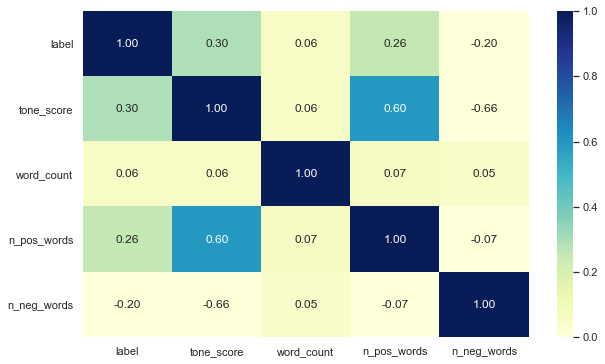

In [68]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1)
plt.show()

# Tokenize and vectorize

In [71]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized


## Tokenize train_df

In [73]:
tokenized = tokenize_df(train_tone_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_tone_df['tokenized'] = tokenized
train_tone_df['token_ids'] = token_ids
train_tone_df['tokenized_text'] = train_tone_df['tokenized'].apply(lambda x: " ".join(x))


len(tokenized):  4211
['accord', 'gran', 'company', 'plan', 'move', 'production', 'russia', 'although', 'company', 'grow']
len(lemma_docs):  4211
accord gran company plan move production russia although company grow
len(all_words):  50206
accord
len(counts):  6302
bow[:20] ['the', 'eur', 'company', 'mn', 'say', 'sale', 'finnish', 'million', 'profit', 'share', 'net', 'operate', 'year', 'finland', 'service', 'group', 'market', 'mln', 'period', 'business']
4211


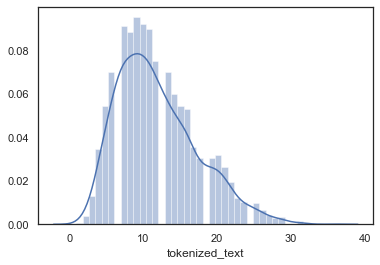

In [74]:
sns.distplot(train_tone_df['tokenized_text'].apply(lambda x: len(x.split())))

In [75]:
len(token_ids[0])

10

## Lemmatize sentiment

In [76]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [77]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   145
Litigious      750
Negative      2355
Positive       354
StrongModal     15
Uncertainty    257

# Modeling and Training
## Common Functions

In [160]:
# Use Stratified KFold Cross Validation
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

In [139]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [84]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


## A. L-M Dictionary
### Train and Test Data

In [86]:
train_tone_df.columns

Index(['sentence', 'label', 'tone_score', 'word_count', 'n_pos_words',
       'n_neg_words', 'pos_words', 'neg_words', 'tokenized', 'token_ids',
       'tokenized_text', 'tfidf_Negative', 'tfidf_Positive',
       'tfidf_Uncertainty', 'tfidf_Litigious', 'tfidf_StrongModal',
       'tfidf_Constraining'],
      dtype='object')

In [88]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   14.2s finished
[2020-07-07 14:30:05,014][INFO] ## Training - acc: 0.65944181, f1: 0.50147315
[2020-07-07 14:30:05,016][INFO] ## Test - acc: 0.62989324, f1: 0.42734983


Best Score:  0.48428494722723103
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1}


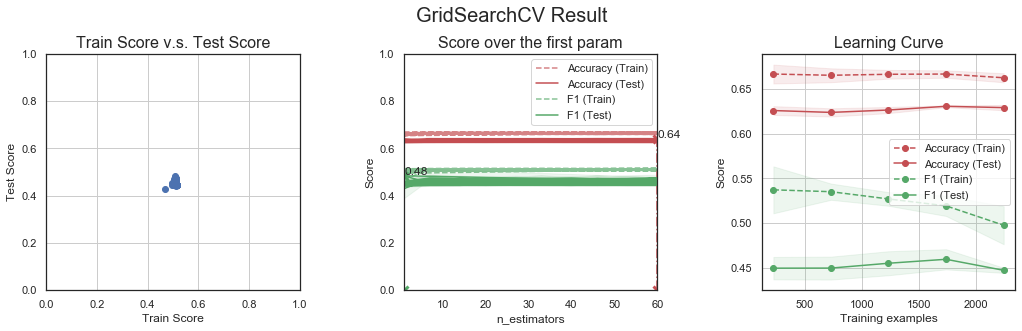

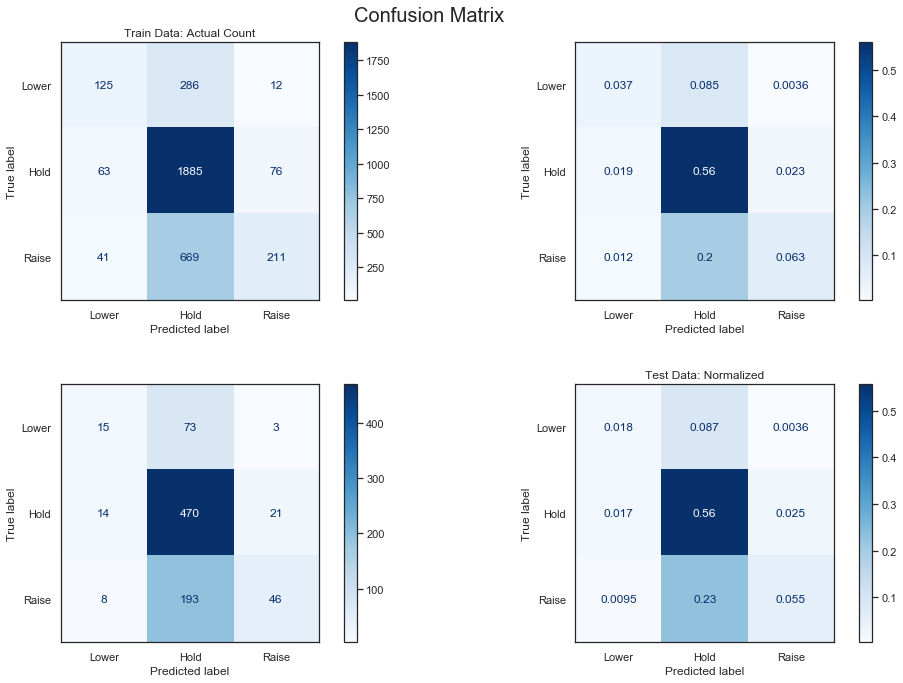

In [91]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Text(0.5, 1.0, 'Feature importance')

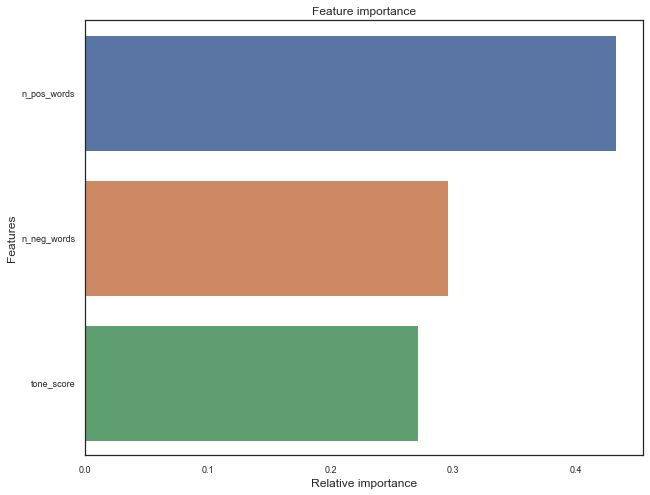

In [92]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


## B. Tfidf
Use Tfidf instead of cosin similarity
### Train and Test Data

In [108]:
train_tone_df

sentence  label  tone_score  \
0     According to Gran , the company has no plans t...      1    0.000000   
1     Technopolis plans to develop in stages an area...      1    0.000000   
2     With the new production plant the company woul...      2    6.250000   
3     According to the company 's updated strategy f...      2    0.000000   
4     For the last quarter of 2010 , Componenta 's n...      2   -2.941176   
...                                                 ...    ...         ...   
4206  HELSINKI Thomson Financial - Shares in Cargote...      0   -5.263158   
4207  LONDON MarketWatch -- Share prices ended lower...      0   -4.347826   
4208  Rinkuskiai 's beer sales fell by 6.5 per cent ...      1    0.000000   
4209  Operating profit fell to EUR 35.4 mn from EUR ...      0    5.882353   
4210  Sales in Finland decreased by 10.5 % in Januar...      0   -7.692308   

      word_count  n_pos_words  n_neg_words                 pos_words  \
0             22            0            0                        []   
1             28            0            0                        []   
2             32            2            0  [improve, profitability]   
3             31            0            0                        []   
4             34            0            1                        []   
...          ...          ...          ...                       ...   
4206          38            0            2                        []   
4207          23            1            2                 [rebound]   
4208          23            0            0                        []   
4209          17            1            0                    [gain]   
4210          13            0            1                        []   

                    neg_words  \
0                          []   
1                          []   
2                          []   
3                          []   
4                      [loss]   
...                       ...   
4206  [sharply, overshadowed]   
4207       [failed, weakness]   
4208                       []   
4209                       []   
4210                [dropped]   

                                              tokenized  \
0     [accord, gran, company, plan, move, production...   
1     [technopolis, plan, develop, stage, area, le, ...   
2     [with, new, production, plant, company, would,...   
3     [accord, company, update, strategy, year, basw...   
4     [for, last, quarter, componenta, net, sale, do...   
...                                                 ...   
4206  [helsinki, thomson, financial, share, cargotec...   
4207  [london, marketwatch, share, price, end, lower...   
4208  [rinkuskiai, beer, sale, fell, per, cent, mill...   
4209  [operate, profit, fell, eur, mn, eur, mn, incl...   
4210  [sale, finland, decrease, january, sale, outsi...   

                                              token_ids  \
0                        [1, 2, 3, 4, 5, 6, 7, 8, 3, 9]   
1     [10, 4, 11, 12, 13, 14, 15, 16, 17, 18, 3, 19,...   
2     [25, 26, 6, 27, 3, 28, 29, 30, 31, 32, 29, 33,...   
3     [1, 3, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,...   
4     [52, 53, 54, 55, 45, 46, 56, 57, 42, 58, 5, 59...   
...                                                 ...   
4206  [137, 1855, 341, 93, 1236, 421, 6181, 2343, 15...   
4207  [1309, 1548, 93, 304, 585, 1644, 1309, 1720, 6...   
4208  [432, 210, 46, 421, 120, 584, 175, 592, 433, 4...   
4209  [49, 50, 421, 63, 64, 63, 64, 302, 1648, 46, 1...   
4210           [46, 107, 352, 212, 46, 1116, 107, 3945]   

                                         tokenized_text  \
0     accord gran company plan move production russi...   
1     technopolis plan develop stage area le square ...   
2     with new production plant company would increa...   
3     accord company update strategy year basware ta...   
4     for last quarter componenta net sale double pe...   
...                                                 ...   
4206  helsinki th

In [165]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df['sentence'].str.lower()
X_data = train_tone_df['tokenized_text']

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [168]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-07 15:43:15,616][INFO] ## Training - acc: 0.86728029, f1: 0.81254734
[2020-07-07 15:43:15,619][INFO] ## Test - acc: 0.76275208, f1: 0.65885571


In [169]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-07 15:43:18,582][INFO] ## Training - acc: 0.99762470, f1: 0.99557794
[2020-07-07 15:43:18,585][INFO] ## Test - acc: 0.76275208, f1: 0.65518687


Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   33.7s finished


Best Score:  0.6814266427031256
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 150}


[2020-07-07 15:48:16,396][INFO] ## Training - acc: 0.99732779, f1: 0.99531548
[2020-07-07 15:48:16,400][INFO] ## Test - acc: 0.76868327, f1: 0.66699611


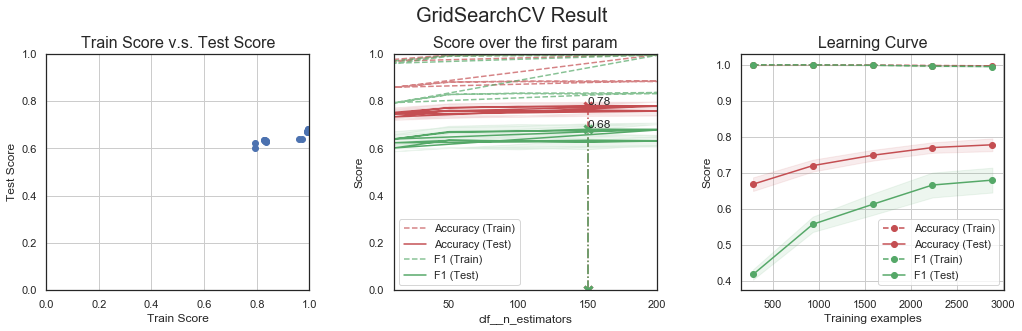

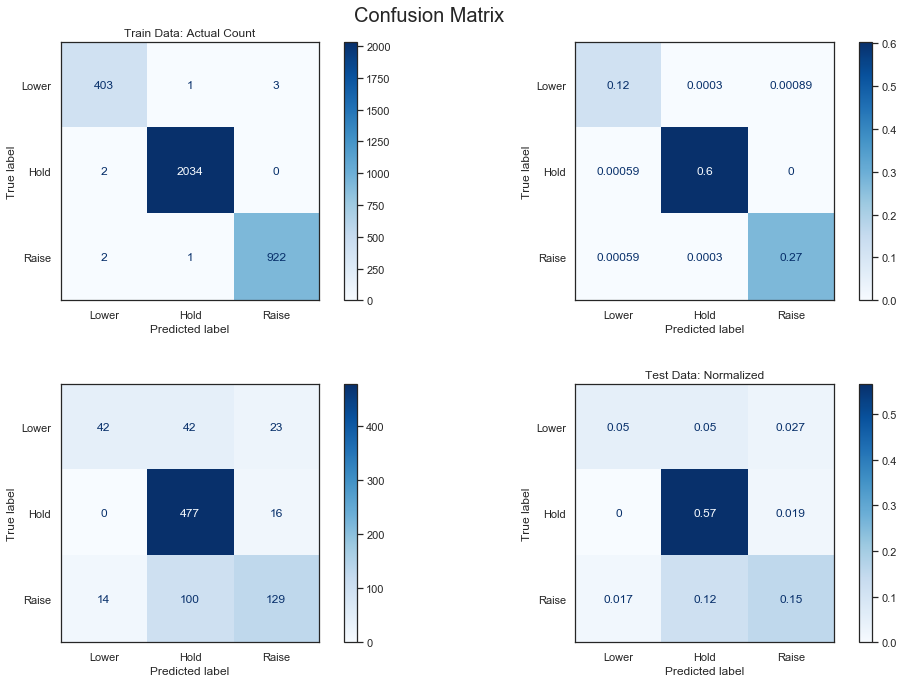

In [173]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)

## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

In [174]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = train_tone_df['token_ids']

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

### Model
#### Embed -> RNN -> Dense -> Softmax

In [183]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [184]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [185]:
def dataloader(messages, labels, sequence_length=80, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [186]:
# Test
text_batch, labels = next(iter(dataloader(X_train, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

tensor([[-1.0011, -0.9701, -1.3724],
        [-0.9951, -0.9981, -1.3404],
        [-1.0754, -0.9838, -1.2554],
        [-1.0521, -1.0034, -1.2582],
        [-0.8592, -1.0654, -1.4614],
        [-1.0283, -1.0025, -1.2894],
        [-0.9731, -1.0313, -1.3259],
        [-0.9786, -1.0111, -1.3459],
        [-0.9327, -1.0614, -1.3450],
        [-1.0101, -0.9370, -1.4106],
        [-1.0530, -0.9669, -1.3061],
        [-1.1737, -0.9539, -1.1857],
        [-1.0788, -0.9637, -1.2782],
        [-0.8692, -1.0969, -1.3993],
        [-1.0647, -0.9783, -1.2758],
        [-0.9811, -1.0335, -1.3118]], grad_fn=<LogSoftmaxBackward>)


### Configure the model and train!

In [187]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(6303, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

In [220]:
def train_model(model, epochs=30, batch_size=32, learning_rate=1e-4, sequence_length=80, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, labels in dataloader(
                        X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Negative', 'Neutral', 'Positive']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/30... Step: 10... Loss: 0.774213... Val Loss: 0.789814 Accuracy: 0.645433 F1 Score: 0.425391
Epoch: 1/30... Step: 20... Loss: 0.591653... Val Loss: 0.785141 Accuracy: 0.649038 F1 Score: 0.432806
Epoch: 1/30... Step: 30... Loss: 0.735677... Val Loss: 0.781169 Accuracy: 0.652644 F1 Score: 0.440418
Epoch: 1/30... Step: 40... Loss: 0.762025... Val Loss: 0.778222 Accuracy: 0.653846 F1 Score: 0.443640
Epoch: 1/30... Step: 50... Loss: 0.680951... Val Loss: 0.775758 Accuracy: 0.653846 F1 Score: 0.445371
Epoch: 1/30... Step: 60... Loss: 0.650836... Val Loss: 0.776011 Accuracy: 0.652644 F1 Score: 0.443186
Epoch: 1/30... Step: 70... Loss: 0.727675... Val Loss: 0.773840 Accuracy: 0.652644 F1 Score: 0.443249
Epoch: 1/30... Step: 80... Loss: 0.848213... Val Loss: 0.773085 Accuracy: 0.652644 F1 Score: 0.443217
Epoch: 1/30... Step: 90... Loss: 0.762542... Val Loss: 0.769127 Accuracy: 0.653846 F1 Score: 0.443192
Epoch: 1/30... Step: 100... Loss: 0.657469... Val Loss: 0.763980 

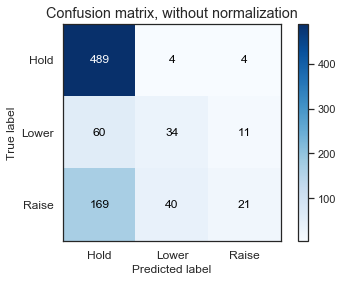

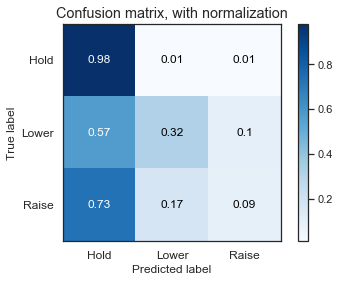

Starting epoch 2
Epoch: 2/30... Step: 10... Loss: 0.730799... Val Loss: 0.760637 Accuracy: 0.657452 F1 Score: 0.450373
Epoch: 2/30... Step: 20... Loss: 0.544933... Val Loss: 0.753928 Accuracy: 0.658654 F1 Score: 0.457911
Epoch: 2/30... Step: 30... Loss: 0.695568... Val Loss: 0.755433 Accuracy: 0.673077 F1 Score: 0.498022
Epoch: 2/30... Step: 40... Loss: 0.725248... Val Loss: 0.749859 Accuracy: 0.663462 F1 Score: 0.467764
Epoch: 2/30... Step: 50... Loss: 0.635248... Val Loss: 0.747867 Accuracy: 0.669471 F1 Score: 0.485158
Epoch: 2/30... Step: 60... Loss: 0.580826... Val Loss: 0.749766 Accuracy: 0.664663 F1 Score: 0.473804
Epoch: 2/30... Step: 70... Loss: 0.720193... Val Loss: 0.745110 Accuracy: 0.673077 F1 Score: 0.491950
Epoch: 2/30... Step: 80... Loss: 0.783565... Val Loss: 0.742995 Accuracy: 0.671875 F1 Score: 0.485788
Epoch: 2/30... Step: 90... Loss: 0.761796... Val Loss: 0.738392 Accuracy: 0.677885 F1 Score: 0.497601
Epoch: 2/30... Step: 100... Loss: 0.543792... Val Loss: 0.734732 

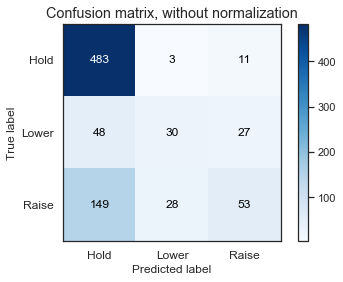

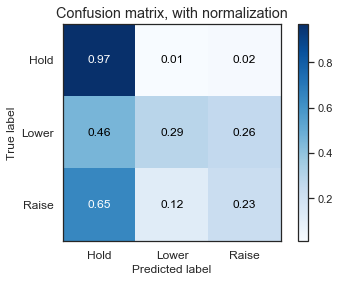

Starting epoch 3
Epoch: 3/30... Step: 10... Loss: 0.688808... Val Loss: 0.731249 Accuracy: 0.683894 F1 Score: 0.514720
Epoch: 3/30... Step: 20... Loss: 0.505264... Val Loss: 0.727395 Accuracy: 0.687500 F1 Score: 0.525758
Epoch: 3/30... Step: 30... Loss: 0.627458... Val Loss: 0.730363 Accuracy: 0.682692 F1 Score: 0.525574
Epoch: 3/30... Step: 40... Loss: 0.643050... Val Loss: 0.724025 Accuracy: 0.686298 F1 Score: 0.500844
Epoch: 3/30... Step: 50... Loss: 0.583983... Val Loss: 0.723126 Accuracy: 0.686298 F1 Score: 0.489286
Epoch: 3/30... Step: 60... Loss: 0.541059... Val Loss: 0.725952 Accuracy: 0.682692 F1 Score: 0.460664
Epoch: 3/30... Step: 70... Loss: 0.678860... Val Loss: 0.720638 Accuracy: 0.688702 F1 Score: 0.480873
Epoch: 3/30... Step: 80... Loss: 0.714240... Val Loss: 0.717261 Accuracy: 0.688702 F1 Score: 0.482207
Epoch: 3/30... Step: 90... Loss: 0.698052... Val Loss: 0.711629 Accuracy: 0.683894 F1 Score: 0.466407
Epoch: 3/30... Step: 100... Loss: 0.448488... Val Loss: 0.713599 

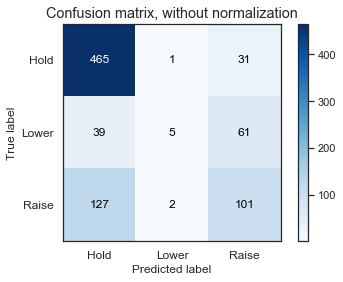

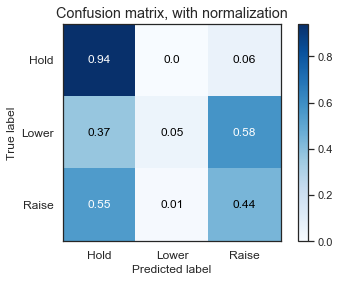

Starting epoch 4
Epoch: 4/30... Step: 10... Loss: 0.632057... Val Loss: 0.710424 Accuracy: 0.687500 F1 Score: 0.459797
Epoch: 4/30... Step: 20... Loss: 0.439035... Val Loss: 0.711778 Accuracy: 0.685096 F1 Score: 0.452629
Epoch: 4/30... Step: 30... Loss: 0.541617... Val Loss: 0.711341 Accuracy: 0.687500 F1 Score: 0.467317
Epoch: 4/30... Step: 40... Loss: 0.525936... Val Loss: 0.708156 Accuracy: 0.692308 F1 Score: 0.466546
Epoch: 4/30... Step: 50... Loss: 0.563122... Val Loss: 0.708003 Accuracy: 0.693510 F1 Score: 0.468881
Epoch: 4/30... Step: 60... Loss: 0.521873... Val Loss: 0.709589 Accuracy: 0.692308 F1 Score: 0.462615
Epoch: 4/30... Step: 70... Loss: 0.648912... Val Loss: 0.712972 Accuracy: 0.683894 F1 Score: 0.452797
Epoch: 4/30... Step: 80... Loss: 0.634159... Val Loss: 0.701360 Accuracy: 0.692308 F1 Score: 0.463891
Epoch: 4/30... Step: 90... Loss: 0.653692... Val Loss: 0.698728 Accuracy: 0.692308 F1 Score: 0.467275
Epoch: 4/30... Step: 100... Loss: 0.369667... Val Loss: 0.702924 

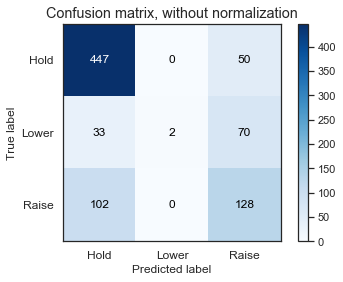

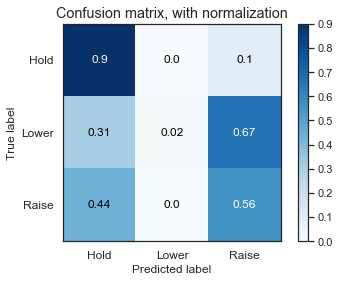

Starting epoch 5
Epoch: 5/30... Step: 10... Loss: 0.598314... Val Loss: 0.706075 Accuracy: 0.695913 F1 Score: 0.475267
Epoch: 5/30... Step: 20... Loss: 0.407187... Val Loss: 0.717056 Accuracy: 0.694712 F1 Score: 0.470141
Epoch: 5/30... Step: 30... Loss: 0.456866... Val Loss: 0.709555 Accuracy: 0.675481 F1 Score: 0.469501
Epoch: 5/30... Step: 40... Loss: 0.432458... Val Loss: 0.705289 Accuracy: 0.693510 F1 Score: 0.475531
Epoch: 5/30... Step: 50... Loss: 0.509565... Val Loss: 0.705277 Accuracy: 0.688702 F1 Score: 0.475020
Epoch: 5/30... Step: 60... Loss: 0.501510... Val Loss: 0.719487 Accuracy: 0.682692 F1 Score: 0.458945
Epoch: 5/30... Step: 70... Loss: 0.584761... Val Loss: 0.708135 Accuracy: 0.692308 F1 Score: 0.469246
Epoch: 5/30... Step: 80... Loss: 0.556119... Val Loss: 0.704534 Accuracy: 0.698317 F1 Score: 0.475418
Epoch: 5/30... Step: 90... Loss: 0.544310... Val Loss: 0.702301 Accuracy: 0.692308 F1 Score: 0.479707
Epoch: 5/30... Step: 100... Loss: 0.317441... Val Loss: 0.709554 

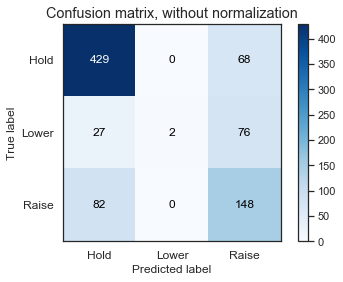

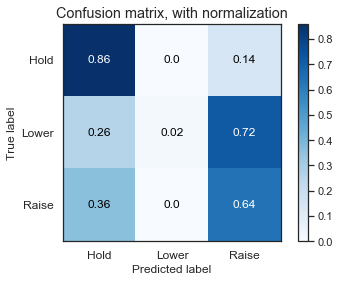

Starting epoch 6
Epoch: 6/30... Step: 10... Loss: 0.540236... Val Loss: 0.730194 Accuracy: 0.693510 F1 Score: 0.477971
Epoch: 6/30... Step: 20... Loss: 0.387746... Val Loss: 0.721305 Accuracy: 0.697115 F1 Score: 0.485102
Epoch: 6/30... Step: 30... Loss: 0.363014... Val Loss: 0.714220 Accuracy: 0.683894 F1 Score: 0.480765
Epoch: 6/30... Step: 40... Loss: 0.360051... Val Loss: 0.727031 Accuracy: 0.688702 F1 Score: 0.478803
Epoch: 6/30... Step: 50... Loss: 0.459809... Val Loss: 0.721512 Accuracy: 0.682692 F1 Score: 0.479643
Epoch: 6/30... Step: 60... Loss: 0.394606... Val Loss: 0.745918 Accuracy: 0.683894 F1 Score: 0.478672
Epoch: 6/30... Step: 70... Loss: 0.561932... Val Loss: 0.731329 Accuracy: 0.697115 F1 Score: 0.531442
Epoch: 6/30... Step: 80... Loss: 0.466684... Val Loss: 0.718451 Accuracy: 0.704327 F1 Score: 0.547116
Epoch: 6/30... Step: 90... Loss: 0.440831... Val Loss: 0.717143 Accuracy: 0.697115 F1 Score: 0.535303
Epoch: 6/30... Step: 100... Loss: 0.279013... Val Loss: 0.717870 

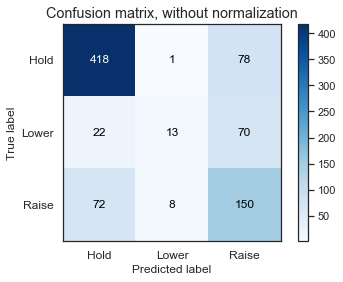

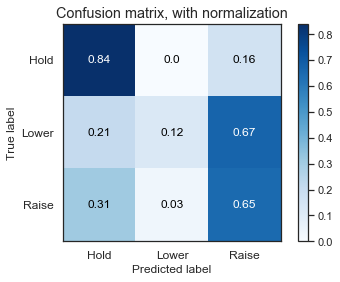

Starting epoch 7
Epoch: 7/30... Step: 10... Loss: 0.458938... Val Loss: 0.737551 Accuracy: 0.687500 F1 Score: 0.528187
Epoch: 7/30... Step: 20... Loss: 0.348197... Val Loss: 0.778152 Accuracy: 0.700721 F1 Score: 0.539557
Epoch: 7/30... Step: 30... Loss: 0.312373... Val Loss: 0.739152 Accuracy: 0.686298 F1 Score: 0.590961
Epoch: 7/30... Step: 40... Loss: 0.277664... Val Loss: 0.767810 Accuracy: 0.701923 F1 Score: 0.563074
Epoch: 7/30... Step: 50... Loss: 0.415023... Val Loss: 0.739599 Accuracy: 0.697115 F1 Score: 0.592382
Epoch: 7/30... Step: 60... Loss: 0.316432... Val Loss: 0.780991 Accuracy: 0.703125 F1 Score: 0.566911
Epoch: 7/30... Step: 70... Loss: 0.543821... Val Loss: 0.738081 Accuracy: 0.699519 F1 Score: 0.581143
Epoch: 7/30... Step: 80... Loss: 0.414993... Val Loss: 0.749256 Accuracy: 0.709135 F1 Score: 0.587360
Epoch: 7/30... Step: 90... Loss: 0.386238... Val Loss: 0.735379 Accuracy: 0.715144 F1 Score: 0.625301
Epoch: 7/30... Step: 100... Loss: 0.219973... Val Loss: 0.748871 

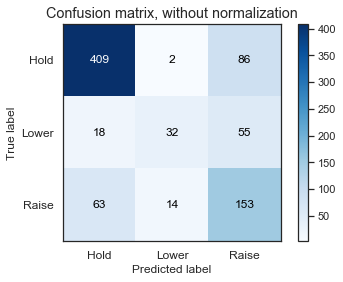

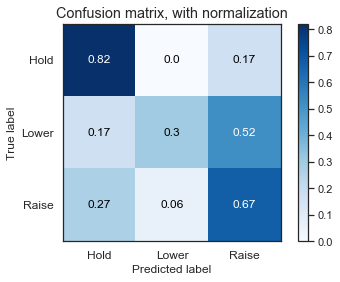

Starting epoch 8
Epoch: 8/30... Step: 10... Loss: 0.333049... Val Loss: 0.760292 Accuracy: 0.712740 F1 Score: 0.598837
Epoch: 8/30... Step: 20... Loss: 0.212862... Val Loss: 0.767470 Accuracy: 0.700721 F1 Score: 0.589123
Epoch: 8/30... Step: 30... Loss: 0.256404... Val Loss: 0.752325 Accuracy: 0.697115 F1 Score: 0.645593
Epoch: 8/30... Step: 40... Loss: 0.216239... Val Loss: 0.838792 Accuracy: 0.706731 F1 Score: 0.584161
Epoch: 8/30... Step: 50... Loss: 0.340199... Val Loss: 0.771864 Accuracy: 0.705529 F1 Score: 0.653421
Epoch: 8/30... Step: 60... Loss: 0.272994... Val Loss: 0.834152 Accuracy: 0.703125 F1 Score: 0.590375
Epoch: 8/30... Step: 70... Loss: 0.447620... Val Loss: 0.751170 Accuracy: 0.722356 F1 Score: 0.658075
Epoch: 8/30... Step: 80... Loss: 0.373870... Val Loss: 0.798641 Accuracy: 0.717548 F1 Score: 0.624049
Epoch: 8/30... Step: 90... Loss: 0.324744... Val Loss: 0.781071 Accuracy: 0.705529 F1 Score: 0.640261
Epoch: 8/30... Step: 100... Loss: 0.200309... Val Loss: 0.788356 

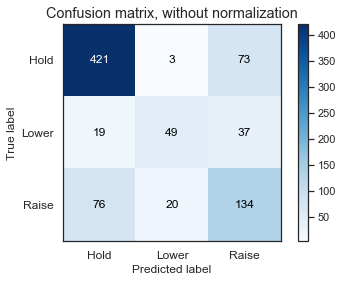

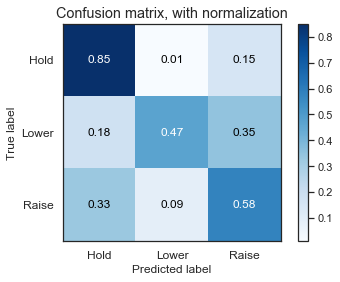

Starting epoch 9
Epoch: 9/30... Step: 10... Loss: 0.249916... Val Loss: 0.823056 Accuracy: 0.712740 F1 Score: 0.613950
Epoch: 9/30... Step: 20... Loss: 0.196325... Val Loss: 0.773359 Accuracy: 0.710337 F1 Score: 0.644102
Epoch: 9/30... Step: 30... Loss: 0.225216... Val Loss: 0.797127 Accuracy: 0.725962 F1 Score: 0.661355
Epoch: 9/30... Step: 40... Loss: 0.174920... Val Loss: 0.812424 Accuracy: 0.717548 F1 Score: 0.656244
Epoch: 9/30... Step: 50... Loss: 0.228394... Val Loss: 0.792860 Accuracy: 0.716346 F1 Score: 0.663210
Epoch: 9/30... Step: 60... Loss: 0.177466... Val Loss: 0.876105 Accuracy: 0.716346 F1 Score: 0.625417
Epoch: 9/30... Step: 70... Loss: 0.377558... Val Loss: 0.773613 Accuracy: 0.721154 F1 Score: 0.661335
Epoch: 9/30... Step: 80... Loss: 0.299923... Val Loss: 0.818182 Accuracy: 0.723558 F1 Score: 0.643876
Epoch: 9/30... Step: 90... Loss: 0.334621... Val Loss: 0.807535 Accuracy: 0.715144 F1 Score: 0.655749
Epoch: 9/30... Step: 100... Loss: 0.133762... Val Loss: 0.881783 

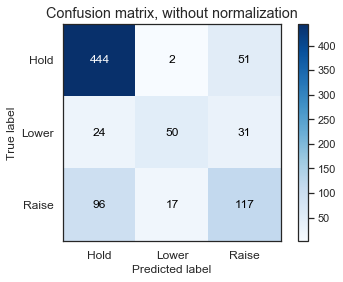

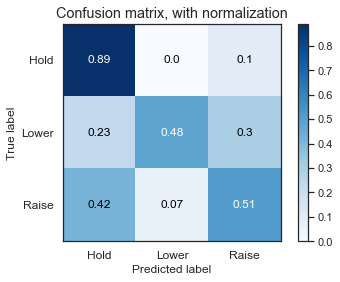

Starting epoch 10
Epoch: 10/30... Step: 10... Loss: 0.212588... Val Loss: 0.846397 Accuracy: 0.719952 F1 Score: 0.655655
Epoch: 10/30... Step: 20... Loss: 0.135859... Val Loss: 0.804124 Accuracy: 0.718750 F1 Score: 0.652586
Epoch: 10/30... Step: 30... Loss: 0.124645... Val Loss: 0.828945 Accuracy: 0.723558 F1 Score: 0.660094
Epoch: 10/30... Step: 40... Loss: 0.128089... Val Loss: 0.862077 Accuracy: 0.713942 F1 Score: 0.659783
Epoch: 10/30... Step: 50... Loss: 0.147635... Val Loss: 0.860495 Accuracy: 0.719952 F1 Score: 0.659169
Epoch: 10/30... Step: 60... Loss: 0.216484... Val Loss: 0.837058 Accuracy: 0.718750 F1 Score: 0.656734
Epoch: 10/30... Step: 70... Loss: 0.294110... Val Loss: 0.901527 Accuracy: 0.724760 F1 Score: 0.648206
Epoch: 10/30... Step: 80... Loss: 0.228794... Val Loss: 0.822144 Accuracy: 0.713942 F1 Score: 0.648676
Epoch: 10/30... Step: 90... Loss: 0.268102... Val Loss: 0.890961 Accuracy: 0.722356 F1 Score: 0.662877
Epoch: 10/30... Step: 100... Loss: 0.099606... Val Loss

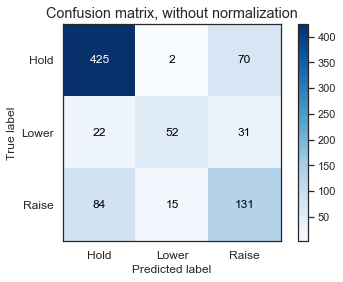

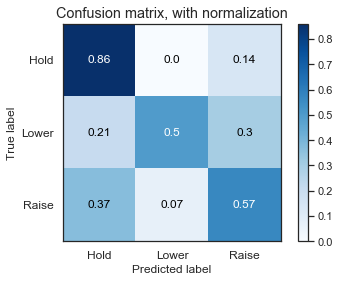

Starting epoch 11
Epoch: 11/30... Step: 10... Loss: 0.303680... Val Loss: 0.917642 Accuracy: 0.711538 F1 Score: 0.658117
Epoch: 11/30... Step: 20... Loss: 0.086774... Val Loss: 0.927719 Accuracy: 0.731971 F1 Score: 0.647545
Epoch: 11/30... Step: 30... Loss: 0.142716... Val Loss: 0.858446 Accuracy: 0.710337 F1 Score: 0.654765
Epoch: 11/30... Step: 40... Loss: 0.094906... Val Loss: 0.935461 Accuracy: 0.722356 F1 Score: 0.652188
Epoch: 11/30... Step: 50... Loss: 0.110583... Val Loss: 0.907318 Accuracy: 0.724760 F1 Score: 0.666897
Epoch: 11/30... Step: 60... Loss: 0.130875... Val Loss: 0.884722 Accuracy: 0.725962 F1 Score: 0.665731
Epoch: 11/30... Step: 70... Loss: 0.302043... Val Loss: 0.975342 Accuracy: 0.731971 F1 Score: 0.652013
Epoch: 11/30... Step: 80... Loss: 0.183635... Val Loss: 0.882334 Accuracy: 0.722356 F1 Score: 0.660835
Epoch: 11/30... Step: 90... Loss: 0.251638... Val Loss: 0.948967 Accuracy: 0.725962 F1 Score: 0.664468
Epoch: 11/30... Step: 100... Loss: 0.059237... Val Loss

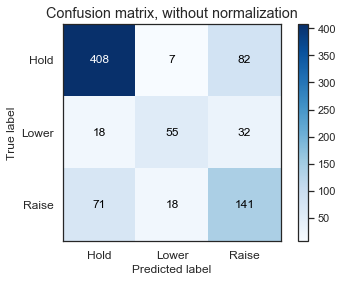

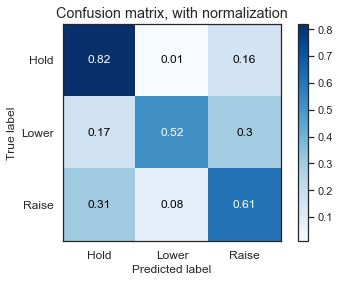

Starting epoch 12
Epoch: 12/30... Step: 10... Loss: 0.117822... Val Loss: 0.976888 Accuracy: 0.722356 F1 Score: 0.653435
Epoch: 12/30... Step: 20... Loss: 0.078128... Val Loss: 0.911882 Accuracy: 0.715144 F1 Score: 0.657588
Epoch: 12/30... Step: 30... Loss: 0.067567... Val Loss: 0.964421 Accuracy: 0.712740 F1 Score: 0.641359
Epoch: 12/30... Step: 40... Loss: 0.127593... Val Loss: 0.971695 Accuracy: 0.711538 F1 Score: 0.656960
Epoch: 12/30... Step: 50... Loss: 0.090901... Val Loss: 1.011408 Accuracy: 0.721154 F1 Score: 0.653410
Epoch: 12/30... Step: 60... Loss: 0.091934... Val Loss: 0.959959 Accuracy: 0.715144 F1 Score: 0.660746
Epoch: 12/30... Step: 70... Loss: 0.273258... Val Loss: 1.005266 Accuracy: 0.729567 F1 Score: 0.644362
Epoch: 12/30... Step: 80... Loss: 0.174853... Val Loss: 0.963997 Accuracy: 0.717548 F1 Score: 0.644150
Epoch: 12/30... Step: 90... Loss: 0.195689... Val Loss: 0.983010 Accuracy: 0.713942 F1 Score: 0.652384
Epoch: 12/30... Step: 100... Loss: 0.045969... Val Loss

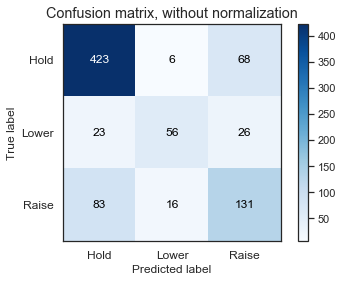

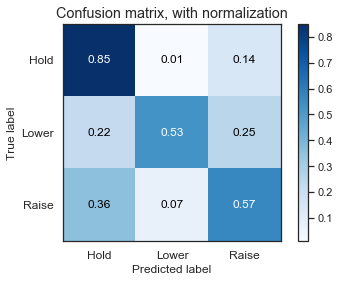

Starting epoch 13
Epoch: 13/30... Step: 10... Loss: 0.118376... Val Loss: 1.068313 Accuracy: 0.716346 F1 Score: 0.643441
Epoch: 13/30... Step: 20... Loss: 0.071056... Val Loss: 0.957177 Accuracy: 0.718750 F1 Score: 0.666689
Epoch: 13/30... Step: 30... Loss: 0.051278... Val Loss: 1.033092 Accuracy: 0.712740 F1 Score: 0.639172
Epoch: 13/30... Step: 40... Loss: 0.131996... Val Loss: 1.031833 Accuracy: 0.706731 F1 Score: 0.667029
Epoch: 13/30... Step: 50... Loss: 0.078942... Val Loss: 1.074952 Accuracy: 0.731971 F1 Score: 0.659570
Epoch: 13/30... Step: 60... Loss: 0.138057... Val Loss: 1.011684 Accuracy: 0.706731 F1 Score: 0.663342
Epoch: 13/30... Step: 70... Loss: 0.258139... Val Loss: 1.028677 Accuracy: 0.731971 F1 Score: 0.655301
Epoch: 13/30... Step: 80... Loss: 0.164708... Val Loss: 1.015717 Accuracy: 0.728365 F1 Score: 0.654934
Epoch: 13/30... Step: 90... Loss: 0.137626... Val Loss: 1.031788 Accuracy: 0.718750 F1 Score: 0.660180
Epoch: 13/30... Step: 100... Loss: 0.036706... Val Loss

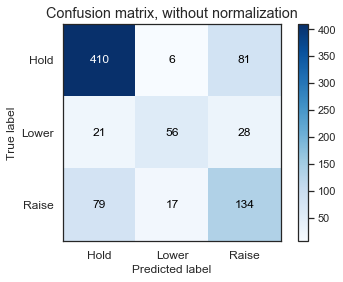

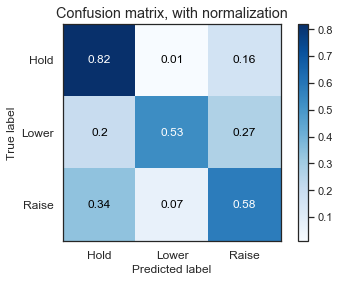

Starting epoch 14
Epoch: 14/30... Step: 10... Loss: 0.082175... Val Loss: 1.140425 Accuracy: 0.722356 F1 Score: 0.659412
Epoch: 14/30... Step: 20... Loss: 0.043513... Val Loss: 1.030983 Accuracy: 0.719952 F1 Score: 0.667290
Epoch: 14/30... Step: 30... Loss: 0.061561... Val Loss: 1.055214 Accuracy: 0.723558 F1 Score: 0.658150
Epoch: 14/30... Step: 40... Loss: 0.073224... Val Loss: 1.083523 Accuracy: 0.707933 F1 Score: 0.649131
Epoch: 14/30... Step: 50... Loss: 0.072844... Val Loss: 1.126064 Accuracy: 0.717548 F1 Score: 0.658178
Epoch: 14/30... Step: 60... Loss: 0.056877... Val Loss: 1.118765 Accuracy: 0.718750 F1 Score: 0.655111
Epoch: 14/30... Step: 70... Loss: 0.211437... Val Loss: 1.075360 Accuracy: 0.713942 F1 Score: 0.649824
Epoch: 14/30... Step: 80... Loss: 0.216464... Val Loss: 1.174352 Accuracy: 0.729567 F1 Score: 0.650349
Epoch: 14/30... Step: 90... Loss: 0.113214... Val Loss: 1.107771 Accuracy: 0.715144 F1 Score: 0.656608
Epoch: 14/30... Step: 100... Loss: 0.028645... Val Loss

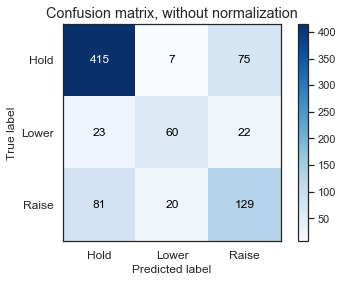

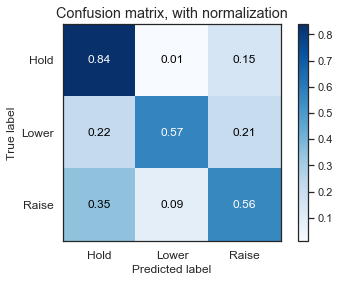

Starting epoch 15
Epoch: 15/30... Step: 10... Loss: 0.059014... Val Loss: 1.192072 Accuracy: 0.721154 F1 Score: 0.662306
Epoch: 15/30... Step: 20... Loss: 0.049428... Val Loss: 1.095768 Accuracy: 0.713942 F1 Score: 0.661278
Epoch: 15/30... Step: 30... Loss: 0.028329... Val Loss: 1.129875 Accuracy: 0.722356 F1 Score: 0.652961
Epoch: 15/30... Step: 40... Loss: 0.077543... Val Loss: 1.099909 Accuracy: 0.710337 F1 Score: 0.661436
Epoch: 15/30... Step: 50... Loss: 0.055302... Val Loss: 1.142668 Accuracy: 0.718750 F1 Score: 0.663914
Epoch: 15/30... Step: 60... Loss: 0.033815... Val Loss: 1.145099 Accuracy: 0.717548 F1 Score: 0.661191
Epoch: 15/30... Step: 70... Loss: 0.195631... Val Loss: 1.102405 Accuracy: 0.709135 F1 Score: 0.658098
Epoch: 15/30... Step: 80... Loss: 0.200318... Val Loss: 1.233882 Accuracy: 0.725962 F1 Score: 0.636140
Epoch: 15/30... Step: 90... Loss: 0.084058... Val Loss: 1.131095 Accuracy: 0.712740 F1 Score: 0.658813
Epoch: 15/30... Step: 100... Loss: 0.038619... Val Loss

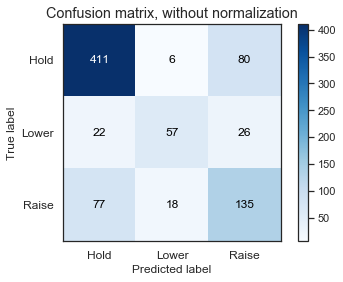

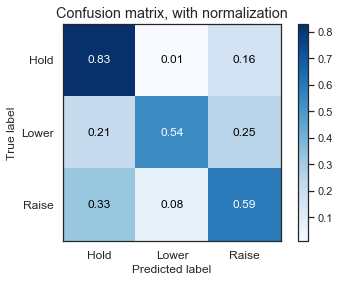

Starting epoch 16
Epoch: 16/30... Step: 10... Loss: 0.051752... Val Loss: 1.229125 Accuracy: 0.717548 F1 Score: 0.661278
Epoch: 16/30... Step: 20... Loss: 0.024288... Val Loss: 1.158123 Accuracy: 0.715144 F1 Score: 0.668634
Epoch: 16/30... Step: 30... Loss: 0.018651... Val Loss: 1.163150 Accuracy: 0.721154 F1 Score: 0.660645
Epoch: 16/30... Step: 40... Loss: 0.058640... Val Loss: 1.165272 Accuracy: 0.722356 F1 Score: 0.668566
Epoch: 16/30... Step: 50... Loss: 0.048013... Val Loss: 1.166391 Accuracy: 0.713942 F1 Score: 0.659996
Epoch: 16/30... Step: 60... Loss: 0.026650... Val Loss: 1.216820 Accuracy: 0.731971 F1 Score: 0.662171
Epoch: 16/30... Step: 70... Loss: 0.300476... Val Loss: 1.167804 Accuracy: 0.716346 F1 Score: 0.666460
Epoch: 16/30... Step: 80... Loss: 0.178343... Val Loss: 1.257925 Accuracy: 0.725962 F1 Score: 0.640331
Epoch: 16/30... Step: 90... Loss: 0.159550... Val Loss: 1.157727 Accuracy: 0.722356 F1 Score: 0.663122
Epoch: 16/30... Step: 100... Loss: 0.044604... Val Loss

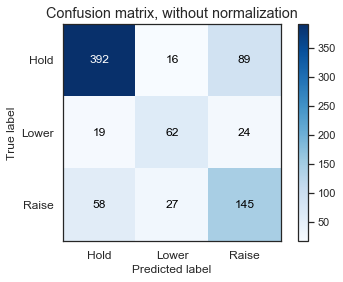

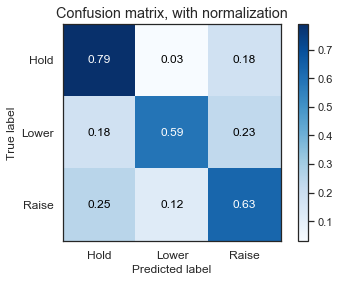

Starting epoch 17
Epoch: 17/30... Step: 10... Loss: 0.057771... Val Loss: 1.233533 Accuracy: 0.724760 F1 Score: 0.668999
Epoch: 17/30... Step: 20... Loss: 0.022170... Val Loss: 1.150968 Accuracy: 0.716346 F1 Score: 0.663582
Epoch: 17/30... Step: 30... Loss: 0.028816... Val Loss: 1.156303 Accuracy: 0.730769 F1 Score: 0.666380
Epoch: 17/30... Step: 40... Loss: 0.083798... Val Loss: 1.153654 Accuracy: 0.719952 F1 Score: 0.662878
Epoch: 17/30... Step: 50... Loss: 0.035987... Val Loss: 1.186714 Accuracy: 0.716346 F1 Score: 0.659997
Epoch: 17/30... Step: 60... Loss: 0.026280... Val Loss: 1.214458 Accuracy: 0.729567 F1 Score: 0.666503
Epoch: 17/30... Step: 70... Loss: 0.209771... Val Loss: 1.157025 Accuracy: 0.706731 F1 Score: 0.649332
Epoch: 17/30... Step: 80... Loss: 0.159948... Val Loss: 1.192474 Accuracy: 0.730769 F1 Score: 0.657212
Epoch: 17/30... Step: 90... Loss: 0.132493... Val Loss: 1.225811 Accuracy: 0.730769 F1 Score: 0.663409
Epoch: 17/30... Step: 100... Loss: 0.039369... Val Loss

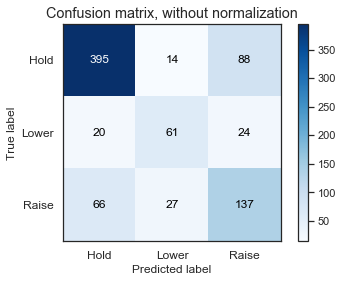

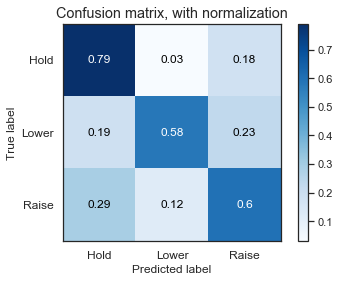

Starting epoch 18
Epoch: 18/30... Step: 10... Loss: 0.062588... Val Loss: 1.364276 Accuracy: 0.742788 F1 Score: 0.672563
Epoch: 18/30... Step: 20... Loss: 0.050300... Val Loss: 1.208797 Accuracy: 0.699519 F1 Score: 0.651904
Epoch: 18/30... Step: 30... Loss: 0.017626... Val Loss: 1.213417 Accuracy: 0.713942 F1 Score: 0.652274
Epoch: 18/30... Step: 40... Loss: 0.106517... Val Loss: 1.217145 Accuracy: 0.718750 F1 Score: 0.660100
Epoch: 18/30... Step: 50... Loss: 0.043009... Val Loss: 1.239928 Accuracy: 0.727163 F1 Score: 0.667606
Epoch: 18/30... Step: 60... Loss: 0.024688... Val Loss: 1.266879 Accuracy: 0.728365 F1 Score: 0.665679
Epoch: 18/30... Step: 70... Loss: 0.294932... Val Loss: 1.215525 Accuracy: 0.722356 F1 Score: 0.665520
Epoch: 18/30... Step: 80... Loss: 0.157168... Val Loss: 1.189432 Accuracy: 0.731971 F1 Score: 0.666066
Epoch: 18/30... Step: 90... Loss: 0.216337... Val Loss: 1.333213 Accuracy: 0.737981 F1 Score: 0.661794
Epoch: 18/30... Step: 100... Loss: 0.027634... Val Loss

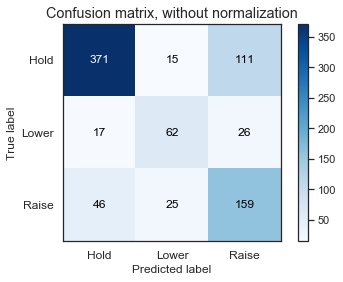

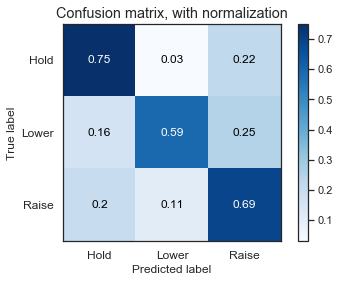

Starting epoch 19
Epoch: 19/30... Step: 10... Loss: 0.041136... Val Loss: 1.387251 Accuracy: 0.740385 F1 Score: 0.664036
Epoch: 19/30... Step: 20... Loss: 0.010379... Val Loss: 1.234419 Accuracy: 0.712740 F1 Score: 0.663352
Epoch: 19/30... Step: 30... Loss: 0.023698... Val Loss: 1.246253 Accuracy: 0.712740 F1 Score: 0.661345
Epoch: 19/30... Step: 40... Loss: 0.079448... Val Loss: 1.285443 Accuracy: 0.728365 F1 Score: 0.667443
Epoch: 19/30... Step: 50... Loss: 0.038079... Val Loss: 1.253107 Accuracy: 0.716346 F1 Score: 0.664179
Epoch: 19/30... Step: 60... Loss: 0.027154... Val Loss: 1.316515 Accuracy: 0.734375 F1 Score: 0.670426
Epoch: 19/30... Step: 70... Loss: 0.242126... Val Loss: 1.250034 Accuracy: 0.728365 F1 Score: 0.671687
Epoch: 19/30... Step: 80... Loss: 0.131997... Val Loss: 1.221572 Accuracy: 0.728365 F1 Score: 0.671762
Epoch: 19/30... Step: 90... Loss: 0.181522... Val Loss: 1.375593 Accuracy: 0.739183 F1 Score: 0.662800
Epoch: 19/30... Step: 100... Loss: 0.014553... Val Loss

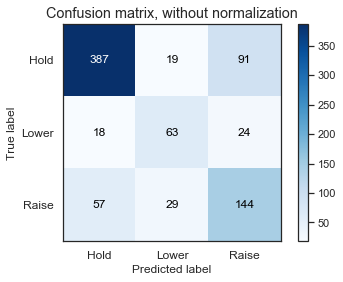

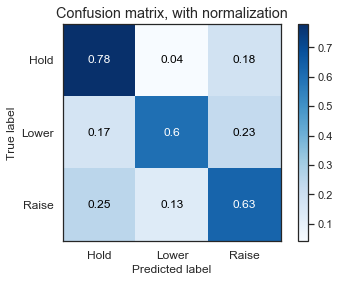

Starting epoch 20
Epoch: 20/30... Step: 10... Loss: 0.027650... Val Loss: 1.384904 Accuracy: 0.736779 F1 Score: 0.664686
Epoch: 20/30... Step: 20... Loss: 0.005144... Val Loss: 1.278784 Accuracy: 0.735577 F1 Score: 0.679069
Epoch: 20/30... Step: 30... Loss: 0.036316... Val Loss: 1.271731 Accuracy: 0.703125 F1 Score: 0.661013
Epoch: 20/30... Step: 40... Loss: 0.042152... Val Loss: 1.280865 Accuracy: 0.735577 F1 Score: 0.677557
Epoch: 20/30... Step: 50... Loss: 0.029081... Val Loss: 1.296759 Accuracy: 0.734375 F1 Score: 0.673379
Epoch: 20/30... Step: 60... Loss: 0.025289... Val Loss: 1.296142 Accuracy: 0.734375 F1 Score: 0.677798
Epoch: 20/30... Step: 70... Loss: 0.209095... Val Loss: 1.284425 Accuracy: 0.733173 F1 Score: 0.676396
Epoch: 20/30... Step: 80... Loss: 0.130989... Val Loss: 1.262514 Accuracy: 0.733173 F1 Score: 0.676102
Epoch: 20/30... Step: 90... Loss: 0.128169... Val Loss: 1.359698 Accuracy: 0.740385 F1 Score: 0.669473
Epoch: 20/30... Step: 100... Loss: 0.012910... Val Loss

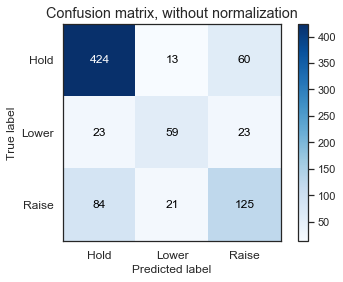

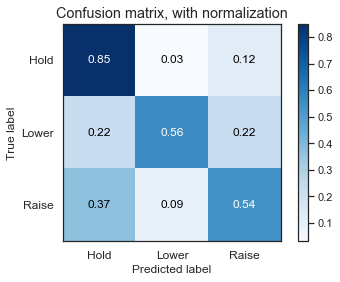

Starting epoch 21
Epoch: 21/30... Step: 10... Loss: 0.037864... Val Loss: 1.376549 Accuracy: 0.729567 F1 Score: 0.670676
Epoch: 21/30... Step: 20... Loss: 0.010215... Val Loss: 1.476126 Accuracy: 0.737981 F1 Score: 0.669933
Epoch: 21/30... Step: 30... Loss: 0.006916... Val Loss: 1.346704 Accuracy: 0.715144 F1 Score: 0.658086
Epoch: 21/30... Step: 40... Loss: 0.086172... Val Loss: 1.353218 Accuracy: 0.712740 F1 Score: 0.657446
Epoch: 21/30... Step: 50... Loss: 0.022771... Val Loss: 1.415282 Accuracy: 0.736779 F1 Score: 0.671306
Epoch: 21/30... Step: 60... Loss: 0.010370... Val Loss: 1.354931 Accuracy: 0.733173 F1 Score: 0.669837
Epoch: 21/30... Step: 70... Loss: 0.207532... Val Loss: 1.306044 Accuracy: 0.731971 F1 Score: 0.670331
Epoch: 21/30... Step: 80... Loss: 0.127595... Val Loss: 1.283266 Accuracy: 0.733173 F1 Score: 0.673747
Epoch: 21/30... Step: 90... Loss: 0.122509... Val Loss: 1.376896 Accuracy: 0.737981 F1 Score: 0.667359
Epoch: 21/30... Step: 100... Loss: 0.008731... Val Loss

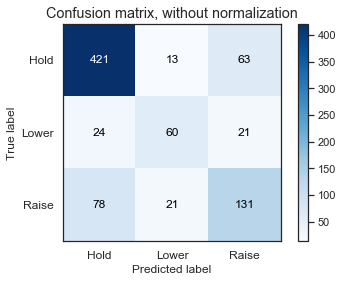

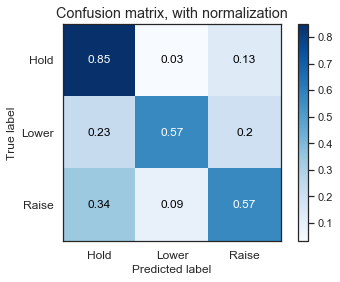

Starting epoch 22
Epoch: 22/30... Step: 10... Loss: 0.025390... Val Loss: 1.447219 Accuracy: 0.733173 F1 Score: 0.672076
Epoch: 22/30... Step: 20... Loss: 0.002917... Val Loss: 1.423031 Accuracy: 0.737981 F1 Score: 0.680327
Epoch: 22/30... Step: 30... Loss: 0.007340... Val Loss: 1.390204 Accuracy: 0.729567 F1 Score: 0.669272
Epoch: 22/30... Step: 40... Loss: 0.065214... Val Loss: 1.359216 Accuracy: 0.722356 F1 Score: 0.669877
Epoch: 22/30... Step: 50... Loss: 0.020304... Val Loss: 1.433395 Accuracy: 0.733173 F1 Score: 0.669502
Epoch: 22/30... Step: 60... Loss: 0.017541... Val Loss: 1.429133 Accuracy: 0.734375 F1 Score: 0.664366
Epoch: 22/30... Step: 70... Loss: 0.174424... Val Loss: 1.314887 Accuracy: 0.722356 F1 Score: 0.673383
Epoch: 22/30... Step: 80... Loss: 0.115983... Val Loss: 1.318352 Accuracy: 0.734375 F1 Score: 0.674536
Epoch: 22/30... Step: 90... Loss: 0.099515... Val Loss: 1.436187 Accuracy: 0.745192 F1 Score: 0.677412
Epoch: 22/30... Step: 100... Loss: 0.006724... Val Loss

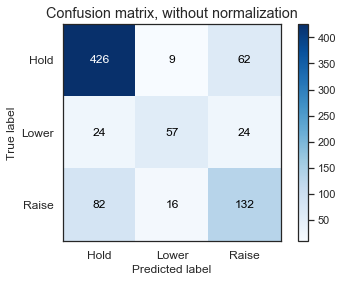

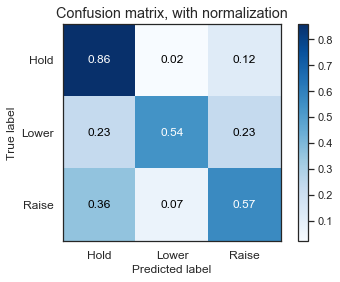

Starting epoch 23
Epoch: 23/30... Step: 10... Loss: 0.013190... Val Loss: 1.465033 Accuracy: 0.733173 F1 Score: 0.674918
Epoch: 23/30... Step: 20... Loss: 0.003926... Val Loss: 1.509052 Accuracy: 0.729567 F1 Score: 0.666611
Epoch: 23/30... Step: 30... Loss: 0.004616... Val Loss: 1.428068 Accuracy: 0.725962 F1 Score: 0.671450
Epoch: 23/30... Step: 40... Loss: 0.081890... Val Loss: 1.428003 Accuracy: 0.713942 F1 Score: 0.664779
Epoch: 23/30... Step: 50... Loss: 0.024319... Val Loss: 1.514102 Accuracy: 0.716346 F1 Score: 0.655348
Epoch: 23/30... Step: 60... Loss: 0.012806... Val Loss: 1.507410 Accuracy: 0.734375 F1 Score: 0.669313
Epoch: 23/30... Step: 70... Loss: 0.175688... Val Loss: 1.410935 Accuracy: 0.736779 F1 Score: 0.677267
Epoch: 23/30... Step: 80... Loss: 0.133910... Val Loss: 1.333315 Accuracy: 0.724760 F1 Score: 0.668318
Epoch: 23/30... Step: 90... Loss: 0.092274... Val Loss: 1.466186 Accuracy: 0.736779 F1 Score: 0.667496
Epoch: 23/30... Step: 100... Loss: 0.006937... Val Loss

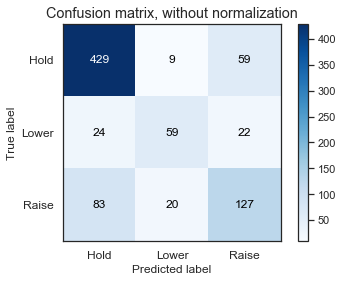

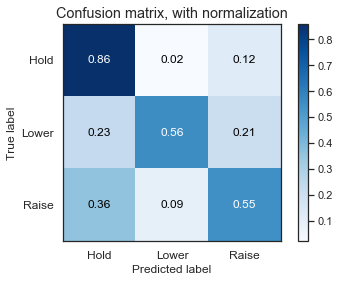

Starting epoch 24
Epoch: 24/30... Step: 10... Loss: 0.013235... Val Loss: 1.529734 Accuracy: 0.728365 F1 Score: 0.665568
Epoch: 24/30... Step: 20... Loss: 0.003347... Val Loss: 1.504141 Accuracy: 0.731971 F1 Score: 0.666148
Epoch: 24/30... Step: 30... Loss: 0.009114... Val Loss: 1.454926 Accuracy: 0.721154 F1 Score: 0.665082
Epoch: 24/30... Step: 40... Loss: 0.055605... Val Loss: 1.477099 Accuracy: 0.716346 F1 Score: 0.664098
Epoch: 24/30... Step: 50... Loss: 0.023222... Val Loss: 1.495042 Accuracy: 0.719952 F1 Score: 0.664222
Epoch: 24/30... Step: 60... Loss: 0.010954... Val Loss: 1.569951 Accuracy: 0.733173 F1 Score: 0.656883
Epoch: 24/30... Step: 70... Loss: 0.194468... Val Loss: 1.434737 Accuracy: 0.735577 F1 Score: 0.673218
Epoch: 24/30... Step: 80... Loss: 0.141799... Val Loss: 1.377259 Accuracy: 0.725962 F1 Score: 0.680129
Epoch: 24/30... Step: 90... Loss: 0.106449... Val Loss: 1.479154 Accuracy: 0.737981 F1 Score: 0.671628
Epoch: 24/30... Step: 100... Loss: 0.007599... Val Loss

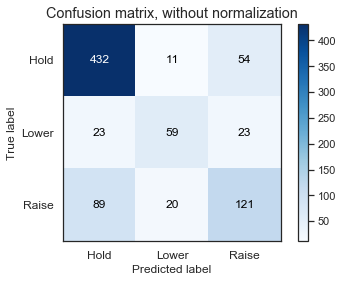

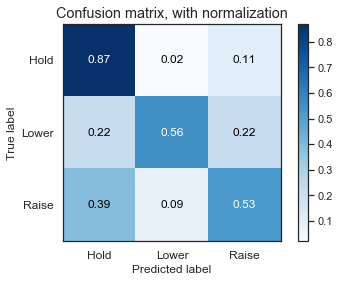

Starting epoch 25
Epoch: 25/30... Step: 10... Loss: 0.010474... Val Loss: 1.605586 Accuracy: 0.733173 F1 Score: 0.664268
Epoch: 25/30... Step: 20... Loss: 0.003421... Val Loss: 1.517247 Accuracy: 0.729567 F1 Score: 0.662134
Epoch: 25/30... Step: 30... Loss: 0.003646... Val Loss: 1.478862 Accuracy: 0.728365 F1 Score: 0.668852
Epoch: 25/30... Step: 40... Loss: 0.052326... Val Loss: 1.499354 Accuracy: 0.722356 F1 Score: 0.669048
Epoch: 25/30... Step: 50... Loss: 0.018639... Val Loss: 1.566596 Accuracy: 0.725962 F1 Score: 0.659631
Epoch: 25/30... Step: 60... Loss: 0.013924... Val Loss: 1.632355 Accuracy: 0.728365 F1 Score: 0.651054
Epoch: 25/30... Step: 70... Loss: 0.251563... Val Loss: 1.550256 Accuracy: 0.734375 F1 Score: 0.665913
Epoch: 25/30... Step: 80... Loss: 0.147026... Val Loss: 1.450796 Accuracy: 0.707933 F1 Score: 0.660713
Epoch: 25/30... Step: 90... Loss: 0.096721... Val Loss: 1.544557 Accuracy: 0.736779 F1 Score: 0.667057
Epoch: 25/30... Step: 100... Loss: 0.011835... Val Loss

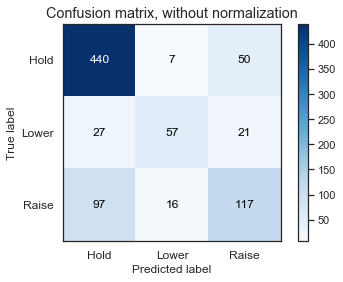

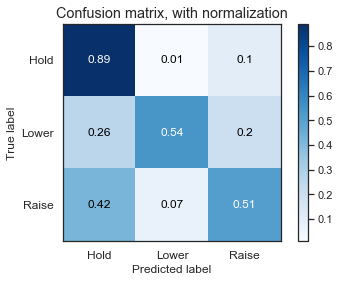

Starting epoch 26
Epoch: 26/30... Step: 10... Loss: 0.011403... Val Loss: 1.563115 Accuracy: 0.724760 F1 Score: 0.668402
Epoch: 26/30... Step: 20... Loss: 0.002373... Val Loss: 1.565438 Accuracy: 0.728365 F1 Score: 0.664419
Epoch: 26/30... Step: 30... Loss: 0.002075... Val Loss: 1.529831 Accuracy: 0.727163 F1 Score: 0.669961
Epoch: 26/30... Step: 40... Loss: 0.018815... Val Loss: 1.524324 Accuracy: 0.721154 F1 Score: 0.666847
Epoch: 26/30... Step: 50... Loss: 0.013990... Val Loss: 1.592698 Accuracy: 0.724760 F1 Score: 0.663592
Epoch: 26/30... Step: 60... Loss: 0.006933... Val Loss: 1.646075 Accuracy: 0.735577 F1 Score: 0.661061
Epoch: 26/30... Step: 70... Loss: 0.256253... Val Loss: 1.548821 Accuracy: 0.731971 F1 Score: 0.664551
Epoch: 26/30... Step: 80... Loss: 0.143567... Val Loss: 1.429584 Accuracy: 0.722356 F1 Score: 0.665335
Epoch: 26/30... Step: 90... Loss: 0.070939... Val Loss: 1.475448 Accuracy: 0.728365 F1 Score: 0.669508
Epoch: 26/30... Step: 100... Loss: 0.009174... Val Loss

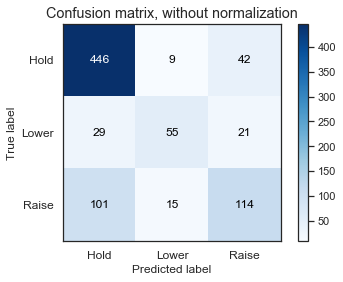

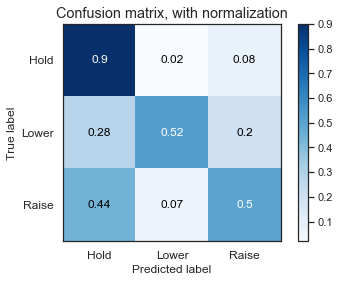

Starting epoch 27
Epoch: 27/30... Step: 10... Loss: 0.005808... Val Loss: 1.560026 Accuracy: 0.718750 F1 Score: 0.668025
Epoch: 27/30... Step: 20... Loss: 0.002879... Val Loss: 1.643111 Accuracy: 0.729567 F1 Score: 0.665240
Epoch: 27/30... Step: 30... Loss: 0.001386... Val Loss: 1.614261 Accuracy: 0.730769 F1 Score: 0.664631
Epoch: 27/30... Step: 40... Loss: 0.068396... Val Loss: 1.579241 Accuracy: 0.718750 F1 Score: 0.665042
Epoch: 27/30... Step: 50... Loss: 0.021538... Val Loss: 1.565463 Accuracy: 0.725962 F1 Score: 0.662109
Epoch: 27/30... Step: 60... Loss: 0.007036... Val Loss: 1.529306 Accuracy: 0.728365 F1 Score: 0.665375
Epoch: 27/30... Step: 70... Loss: 0.075989... Val Loss: 1.533591 Accuracy: 0.734375 F1 Score: 0.669200
Epoch: 27/30... Step: 80... Loss: 0.128751... Val Loss: 1.404772 Accuracy: 0.724760 F1 Score: 0.664314
Epoch: 27/30... Step: 90... Loss: 0.050484... Val Loss: 1.451326 Accuracy: 0.736779 F1 Score: 0.674254
Epoch: 27/30... Step: 100... Loss: 0.007404... Val Loss

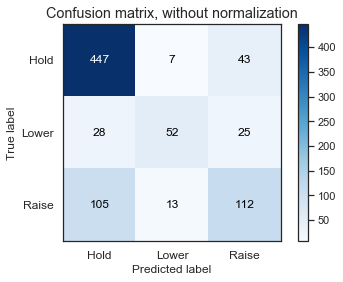

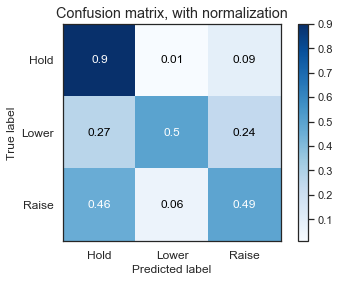

Starting epoch 28
Epoch: 28/30... Step: 10... Loss: 0.012108... Val Loss: 1.586443 Accuracy: 0.729567 F1 Score: 0.670660
Epoch: 28/30... Step: 20... Loss: 0.001576... Val Loss: 1.584103 Accuracy: 0.725962 F1 Score: 0.666218
Epoch: 28/30... Step: 30... Loss: 0.001315... Val Loss: 1.579182 Accuracy: 0.733173 F1 Score: 0.675412
Epoch: 28/30... Step: 40... Loss: 0.035670... Val Loss: 1.572469 Accuracy: 0.721154 F1 Score: 0.668740
Epoch: 28/30... Step: 50... Loss: 0.011003... Val Loss: 1.617161 Accuracy: 0.724760 F1 Score: 0.670696
Epoch: 28/30... Step: 60... Loss: 0.006764... Val Loss: 1.661711 Accuracy: 0.729567 F1 Score: 0.665315
Epoch: 28/30... Step: 70... Loss: 0.166417... Val Loss: 1.654446 Accuracy: 0.730769 F1 Score: 0.667988
Epoch: 28/30... Step: 80... Loss: 0.094630... Val Loss: 1.499188 Accuracy: 0.731971 F1 Score: 0.681543
Epoch: 28/30... Step: 90... Loss: 0.087124... Val Loss: 1.514025 Accuracy: 0.735577 F1 Score: 0.671969
Epoch: 28/30... Step: 100... Loss: 0.003464... Val Loss

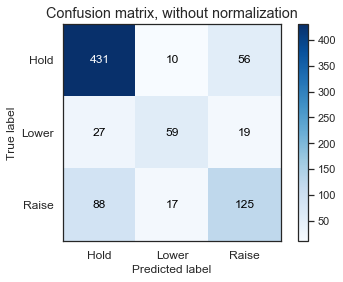

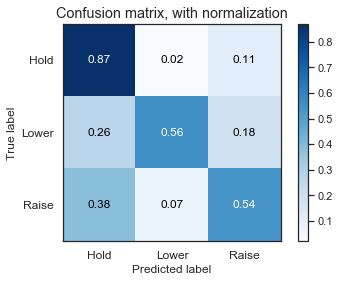

Starting epoch 29
Epoch: 29/30... Step: 10... Loss: 0.008497... Val Loss: 1.636654 Accuracy: 0.735577 F1 Score: 0.667486
Epoch: 29/30... Step: 20... Loss: 0.001289... Val Loss: 1.613819 Accuracy: 0.736779 F1 Score: 0.671521
Epoch: 29/30... Step: 30... Loss: 0.001498... Val Loss: 1.597448 Accuracy: 0.734375 F1 Score: 0.682539
Epoch: 29/30... Step: 40... Loss: 0.028740... Val Loss: 1.638545 Accuracy: 0.727163 F1 Score: 0.677742
Epoch: 29/30... Step: 50... Loss: 0.012003... Val Loss: 1.725250 Accuracy: 0.724760 F1 Score: 0.665966
Epoch: 29/30... Step: 60... Loss: 0.004226... Val Loss: 1.656654 Accuracy: 0.736779 F1 Score: 0.678123
Epoch: 29/30... Step: 70... Loss: 0.181602... Val Loss: 1.660395 Accuracy: 0.730769 F1 Score: 0.666302
Epoch: 29/30... Step: 80... Loss: 0.105033... Val Loss: 1.543730 Accuracy: 0.735577 F1 Score: 0.675396
Epoch: 29/30... Step: 90... Loss: 0.076522... Val Loss: 1.550902 Accuracy: 0.733173 F1 Score: 0.672621
Epoch: 29/30... Step: 100... Loss: 0.003896... Val Loss

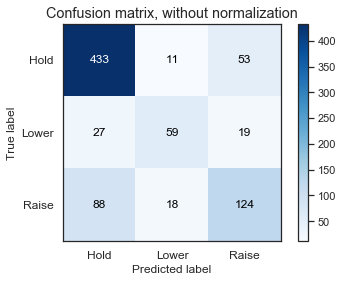

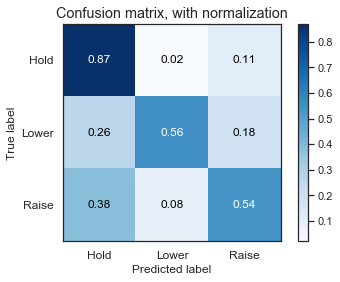

Starting epoch 30
Epoch: 30/30... Step: 10... Loss: 0.008529... Val Loss: 1.689171 Accuracy: 0.737981 F1 Score: 0.670576
Epoch: 30/30... Step: 20... Loss: 0.001007... Val Loss: 1.642365 Accuracy: 0.737981 F1 Score: 0.677303
Epoch: 30/30... Step: 30... Loss: 0.002415... Val Loss: 1.659289 Accuracy: 0.735577 F1 Score: 0.672594
Epoch: 30/30... Step: 40... Loss: 0.024729... Val Loss: 1.660960 Accuracy: 0.724760 F1 Score: 0.666112
Epoch: 30/30... Step: 50... Loss: 0.012715... Val Loss: 1.692629 Accuracy: 0.721154 F1 Score: 0.662254
Epoch: 30/30... Step: 60... Loss: 0.004777... Val Loss: 1.715720 Accuracy: 0.735577 F1 Score: 0.666384
Epoch: 30/30... Step: 70... Loss: 0.150700... Val Loss: 1.744478 Accuracy: 0.734375 F1 Score: 0.662275
Epoch: 30/30... Step: 80... Loss: 0.098202... Val Loss: 1.619130 Accuracy: 0.734375 F1 Score: 0.679223
Epoch: 30/30... Step: 90... Loss: 0.076685... Val Loss: 1.606224 Accuracy: 0.736779 F1 Score: 0.681293
Epoch: 30/30... Step: 100... Loss: 0.002905... Val Loss

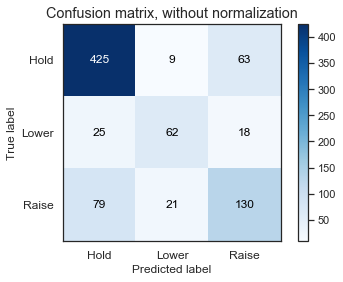

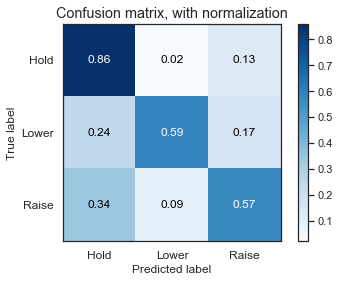

In [191]:
train_model(model)

## D. Glove Word Embedding + LSTM
Use GloVe word embedding instead of Tfidf

### Download GloVe files

In [233]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [234]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [235]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

5471 words found out of 6302 words in vocab.
(6303, 300)


In [236]:
type(weight_matrix)

numpy.ndarray

In [237]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(lstm_size, dense_size)
        # self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        # dense_out = self.fc1(lstm_out)
        # out = self.fc2(dense_out)
        out = self.fc(lstm_out)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [238]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(6303, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/30... Step: 10... Loss: 1.124567... Val Loss: 1.127098 Accuracy: 0.156250 F1 Score: 0.148178
Epoch: 1/30... Step: 20... Loss: 1.115658... Val Loss: 1.110690 Accuracy: 0.217548 F1 Score: 0.207512
Epoch: 1/30... Step: 30... Loss: 1.084508... Val Loss: 1.091770 Accuracy: 0.424279 F1 Score: 0.297770
Epoch: 1/30... Step: 40... Loss: 1.067506... Val Loss: 1.067748 Accuracy: 0.569712 F1 Score: 0.256711
Epoch: 1/30... Step: 50... Loss: 1.016393... Val Loss: 1.029592 Accuracy: 0.594952 F1 Score: 0.248681
Epoch: 1/30... Step: 60... Loss: 0.947576... Val Loss: 0.970833 Accuracy: 0.597356 F1 Score: 0.249310
Epoch: 1/30... Step: 70... Loss: 0.878279... Val Loss: 0.952793 Accuracy: 0.597356 F1 Score: 0.249310
Epoch: 1/30... Step: 80... Loss: 1.049006... Val Loss: 0.946961 Accuracy: 0.597356 F1 Score: 0.249310
Epoch: 1/30... Step: 90... Loss: 0.869887... Val Loss: 0.927514 Accuracy: 0.597356 F1 Score: 0.249310
Epoch: 1/30... Step: 100... Loss: 0.848800... Val Loss: 0.919087 

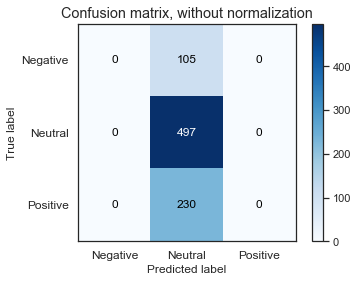

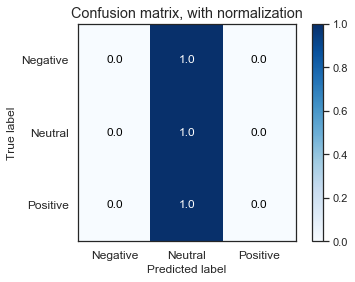

Starting epoch 2
Epoch: 2/30... Step: 10... Loss: 0.872107... Val Loss: 0.910318 Accuracy: 0.597356 F1 Score: 0.249310
Epoch: 2/30... Step: 20... Loss: 0.706064... Val Loss: 0.902651 Accuracy: 0.597356 F1 Score: 0.249686
Epoch: 2/30... Step: 30... Loss: 0.801159... Val Loss: 0.896397 Accuracy: 0.600962 F1 Score: 0.259223
Epoch: 2/30... Step: 40... Loss: 0.837552... Val Loss: 0.889489 Accuracy: 0.603365 F1 Score: 0.265356
Epoch: 2/30... Step: 50... Loss: 0.855237... Val Loss: 0.883691 Accuracy: 0.608173 F1 Score: 0.283190
Epoch: 2/30... Step: 60... Loss: 0.844789... Val Loss: 0.877761 Accuracy: 0.610577 F1 Score: 0.288739
Epoch: 2/30... Step: 70... Loss: 0.780765... Val Loss: 0.873319 Accuracy: 0.612981 F1 Score: 0.294511
Epoch: 2/30... Step: 80... Loss: 0.907981... Val Loss: 0.866026 Accuracy: 0.621394 F1 Score: 0.316424
Epoch: 2/30... Step: 90... Loss: 0.767383... Val Loss: 0.857547 Accuracy: 0.631010 F1 Score: 0.346957
Epoch: 2/30... Step: 100... Loss: 0.821825... Val Loss: 0.848004 

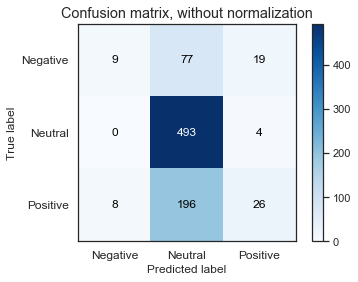

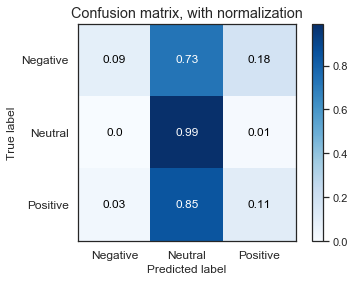

Starting epoch 3
Epoch: 3/30... Step: 10... Loss: 0.846442... Val Loss: 0.838537 Accuracy: 0.644231 F1 Score: 0.397191
Epoch: 3/30... Step: 20... Loss: 0.687120... Val Loss: 0.830343 Accuracy: 0.647837 F1 Score: 0.411980
Epoch: 3/30... Step: 30... Loss: 0.757676... Val Loss: 0.825429 Accuracy: 0.650240 F1 Score: 0.426212
Epoch: 3/30... Step: 40... Loss: 0.822451... Val Loss: 0.821877 Accuracy: 0.650240 F1 Score: 0.432010
Epoch: 3/30... Step: 50... Loss: 0.794680... Val Loss: 0.819105 Accuracy: 0.650240 F1 Score: 0.432256
Epoch: 3/30... Step: 60... Loss: 0.739206... Val Loss: 0.821032 Accuracy: 0.653846 F1 Score: 0.432964
Epoch: 3/30... Step: 70... Loss: 0.749206... Val Loss: 0.817054 Accuracy: 0.652644 F1 Score: 0.436189
Epoch: 3/30... Step: 80... Loss: 0.845995... Val Loss: 0.819065 Accuracy: 0.655048 F1 Score: 0.437947
Epoch: 3/30... Step: 90... Loss: 0.771749... Val Loss: 0.818187 Accuracy: 0.653846 F1 Score: 0.424906
Epoch: 3/30... Step: 100... Loss: 0.824976... Val Loss: 0.810698 

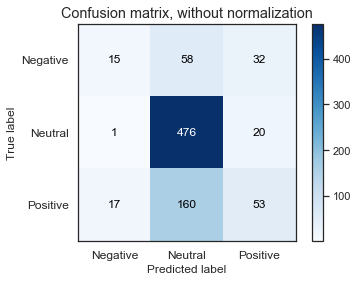

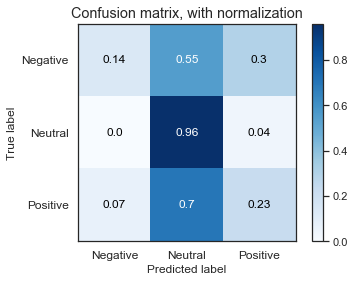

Starting epoch 4
Epoch: 4/30... Step: 10... Loss: 0.828325... Val Loss: 0.810402 Accuracy: 0.655048 F1 Score: 0.427441
Epoch: 4/30... Step: 20... Loss: 0.699864... Val Loss: 0.801605 Accuracy: 0.659856 F1 Score: 0.453503
Epoch: 4/30... Step: 30... Loss: 0.745671... Val Loss: 0.800893 Accuracy: 0.658654 F1 Score: 0.463376
Epoch: 4/30... Step: 40... Loss: 0.789854... Val Loss: 0.796813 Accuracy: 0.663462 F1 Score: 0.460686
Epoch: 4/30... Step: 50... Loss: 0.778440... Val Loss: 0.796092 Accuracy: 0.663462 F1 Score: 0.443048
Epoch: 4/30... Step: 60... Loss: 0.692292... Val Loss: 0.797923 Accuracy: 0.658654 F1 Score: 0.429828
Epoch: 4/30... Step: 70... Loss: 0.752355... Val Loss: 0.795309 Accuracy: 0.658654 F1 Score: 0.435285
Epoch: 4/30... Step: 80... Loss: 0.806229... Val Loss: 0.796577 Accuracy: 0.661058 F1 Score: 0.429058
Epoch: 4/30... Step: 90... Loss: 0.769416... Val Loss: 0.797007 Accuracy: 0.659856 F1 Score: 0.404335
Epoch: 4/30... Step: 100... Loss: 0.823438... Val Loss: 0.790777 

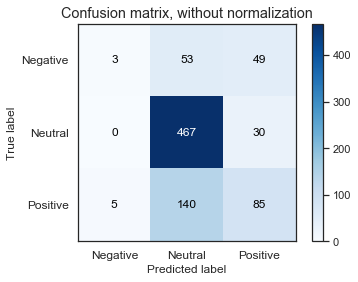

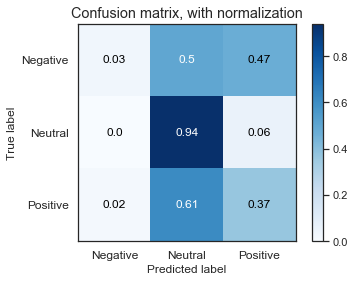

Starting epoch 5
Epoch: 5/30... Step: 10... Loss: 0.823435... Val Loss: 0.790763 Accuracy: 0.659856 F1 Score: 0.403301
Epoch: 5/30... Step: 20... Loss: 0.700682... Val Loss: 0.781467 Accuracy: 0.669471 F1 Score: 0.422003
Epoch: 5/30... Step: 30... Loss: 0.694320... Val Loss: 0.782278 Accuracy: 0.665865 F1 Score: 0.421559
Epoch: 5/30... Step: 40... Loss: 0.758829... Val Loss: 0.777945 Accuracy: 0.670673 F1 Score: 0.420372
Epoch: 5/30... Step: 50... Loss: 0.736578... Val Loss: 0.778427 Accuracy: 0.670673 F1 Score: 0.422557
Epoch: 5/30... Step: 60... Loss: 0.657944... Val Loss: 0.780553 Accuracy: 0.667067 F1 Score: 0.415024
Epoch: 5/30... Step: 70... Loss: 0.734046... Val Loss: 0.777873 Accuracy: 0.668269 F1 Score: 0.416549
Epoch: 5/30... Step: 80... Loss: 0.761621... Val Loss: 0.778151 Accuracy: 0.667067 F1 Score: 0.410924
Epoch: 5/30... Step: 90... Loss: 0.781014... Val Loss: 0.773680 Accuracy: 0.665865 F1 Score: 0.409219
Epoch: 5/30... Step: 100... Loss: 0.801887... Val Loss: 0.772912 

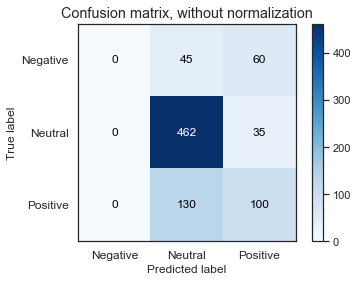

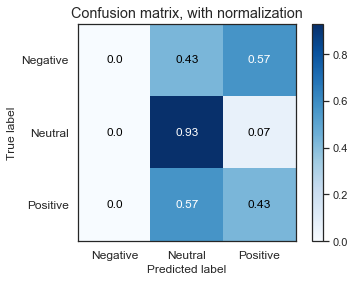

Starting epoch 6
Epoch: 6/30... Step: 10... Loss: 0.807274... Val Loss: 0.772058 Accuracy: 0.667067 F1 Score: 0.409159
Epoch: 6/30... Step: 20... Loss: 0.700716... Val Loss: 0.763899 Accuracy: 0.673077 F1 Score: 0.422823
Epoch: 6/30... Step: 30... Loss: 0.657189... Val Loss: 0.765475 Accuracy: 0.679087 F1 Score: 0.432762
Epoch: 6/30... Step: 40... Loss: 0.745963... Val Loss: 0.762486 Accuracy: 0.674279 F1 Score: 0.427286
Epoch: 6/30... Step: 50... Loss: 0.743857... Val Loss: 0.765224 Accuracy: 0.665865 F1 Score: 0.427804
Epoch: 6/30... Step: 60... Loss: 0.634749... Val Loss: 0.765321 Accuracy: 0.674279 F1 Score: 0.423670
Epoch: 6/30... Step: 70... Loss: 0.689019... Val Loss: 0.762609 Accuracy: 0.675481 F1 Score: 0.424386
Epoch: 6/30... Step: 80... Loss: 0.724746... Val Loss: 0.760943 Accuracy: 0.679087 F1 Score: 0.425904
Epoch: 6/30... Step: 90... Loss: 0.794207... Val Loss: 0.756019 Accuracy: 0.674279 F1 Score: 0.419832
Epoch: 6/30... Step: 100... Loss: 0.795712... Val Loss: 0.756535 

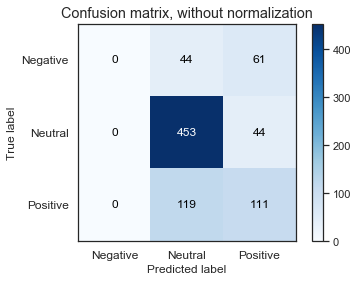

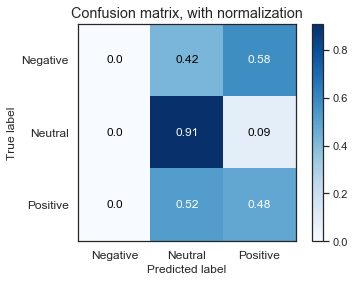

Starting epoch 7
Epoch: 7/30... Step: 10... Loss: 0.772127... Val Loss: 0.755881 Accuracy: 0.675481 F1 Score: 0.420544
Epoch: 7/30... Step: 20... Loss: 0.696966... Val Loss: 0.749005 Accuracy: 0.677885 F1 Score: 0.434773
Epoch: 7/30... Step: 30... Loss: 0.609438... Val Loss: 0.751920 Accuracy: 0.676683 F1 Score: 0.439873
Epoch: 7/30... Step: 40... Loss: 0.704826... Val Loss: 0.749510 Accuracy: 0.668269 F1 Score: 0.432610
Epoch: 7/30... Step: 50... Loss: 0.716456... Val Loss: 0.758836 Accuracy: 0.665865 F1 Score: 0.440445
Epoch: 7/30... Step: 60... Loss: 0.630301... Val Loss: 0.753863 Accuracy: 0.687500 F1 Score: 0.436725
Epoch: 7/30... Step: 70... Loss: 0.660193... Val Loss: 0.746854 Accuracy: 0.679087 F1 Score: 0.448321
Epoch: 7/30... Step: 80... Loss: 0.692450... Val Loss: 0.745241 Accuracy: 0.686298 F1 Score: 0.465352
Epoch: 7/30... Step: 90... Loss: 0.777115... Val Loss: 0.738791 Accuracy: 0.683894 F1 Score: 0.444528
Epoch: 7/30... Step: 100... Loss: 0.781365... Val Loss: 0.745450 

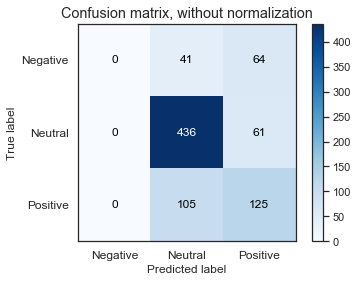

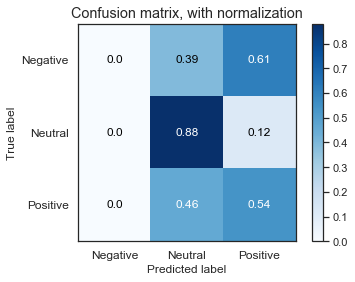

Starting epoch 8
Epoch: 8/30... Step: 10... Loss: 0.733651... Val Loss: 0.741014 Accuracy: 0.682692 F1 Score: 0.433222
Epoch: 8/30... Step: 20... Loss: 0.663619... Val Loss: 0.735492 Accuracy: 0.683894 F1 Score: 0.460286
Epoch: 8/30... Step: 30... Loss: 0.523322... Val Loss: 0.742357 Accuracy: 0.680288 F1 Score: 0.464470
Epoch: 8/30... Step: 40... Loss: 0.693006... Val Loss: 0.737235 Accuracy: 0.674279 F1 Score: 0.440418
Epoch: 8/30... Step: 50... Loss: 0.666617... Val Loss: 0.748546 Accuracy: 0.673077 F1 Score: 0.455630
Epoch: 8/30... Step: 60... Loss: 0.607088... Val Loss: 0.739667 Accuracy: 0.682692 F1 Score: 0.472646
Epoch: 8/30... Step: 70... Loss: 0.645952... Val Loss: 0.733145 Accuracy: 0.682692 F1 Score: 0.501087
Epoch: 8/30... Step: 80... Loss: 0.668672... Val Loss: 0.731898 Accuracy: 0.692308 F1 Score: 0.521564
Epoch: 8/30... Step: 90... Loss: 0.780018... Val Loss: 0.721321 Accuracy: 0.688702 F1 Score: 0.482736
Epoch: 8/30... Step: 100... Loss: 0.707041... Val Loss: 0.728075 

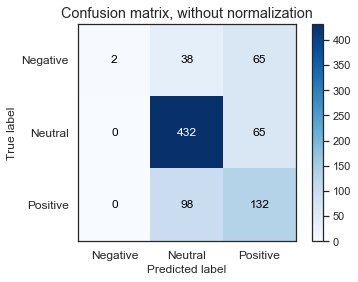

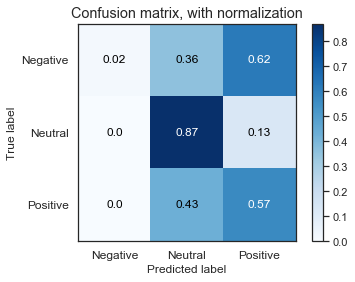

Starting epoch 9
Epoch: 9/30... Step: 10... Loss: 0.691718... Val Loss: 0.721731 Accuracy: 0.688702 F1 Score: 0.462097
Epoch: 9/30... Step: 20... Loss: 0.581826... Val Loss: 0.725224 Accuracy: 0.692308 F1 Score: 0.535229
Epoch: 9/30... Step: 30... Loss: 0.480003... Val Loss: 0.730836 Accuracy: 0.685096 F1 Score: 0.509848
Epoch: 9/30... Step: 40... Loss: 0.653083... Val Loss: 0.728706 Accuracy: 0.680288 F1 Score: 0.476926
Epoch: 9/30... Step: 50... Loss: 0.623942... Val Loss: 0.733888 Accuracy: 0.692308 F1 Score: 0.549000
Epoch: 9/30... Step: 60... Loss: 0.594729... Val Loss: 0.726202 Accuracy: 0.691106 F1 Score: 0.515676
Epoch: 9/30... Step: 70... Loss: 0.621540... Val Loss: 0.723731 Accuracy: 0.679087 F1 Score: 0.520528
Epoch: 9/30... Step: 80... Loss: 0.621002... Val Loss: 0.715869 Accuracy: 0.701923 F1 Score: 0.555320
Epoch: 9/30... Step: 90... Loss: 0.739019... Val Loss: 0.709773 Accuracy: 0.693510 F1 Score: 0.510747
Epoch: 9/30... Step: 100... Loss: 0.652844... Val Loss: 0.727948 

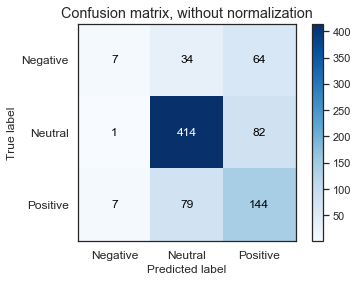

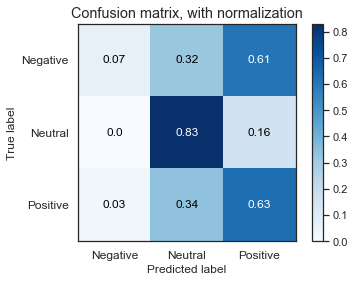

Starting epoch 10
Epoch: 10/30... Step: 10... Loss: 0.676542... Val Loss: 0.713709 Accuracy: 0.692308 F1 Score: 0.506946
Epoch: 10/30... Step: 20... Loss: 0.529582... Val Loss: 0.724087 Accuracy: 0.692308 F1 Score: 0.552218
Epoch: 10/30... Step: 30... Loss: 0.429821... Val Loss: 0.726187 Accuracy: 0.687500 F1 Score: 0.557515
Epoch: 10/30... Step: 40... Loss: 0.648989... Val Loss: 0.715796 Accuracy: 0.689904 F1 Score: 0.526887
Epoch: 10/30... Step: 50... Loss: 0.565627... Val Loss: 0.726727 Accuracy: 0.697115 F1 Score: 0.579953
Epoch: 10/30... Step: 60... Loss: 0.603745... Val Loss: 0.727318 Accuracy: 0.691106 F1 Score: 0.515194
Epoch: 10/30... Step: 70... Loss: 0.598779... Val Loss: 0.714106 Accuracy: 0.687500 F1 Score: 0.567537
Epoch: 10/30... Step: 80... Loss: 0.609806... Val Loss: 0.713568 Accuracy: 0.695913 F1 Score: 0.564698
Epoch: 10/30... Step: 90... Loss: 0.703476... Val Loss: 0.707804 Accuracy: 0.694712 F1 Score: 0.525635
Epoch: 10/30... Step: 100... Loss: 0.566136... Val Loss

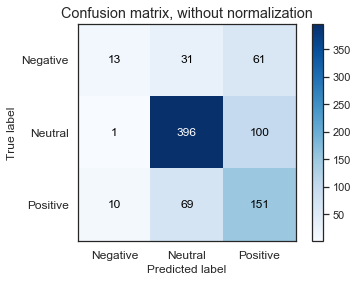

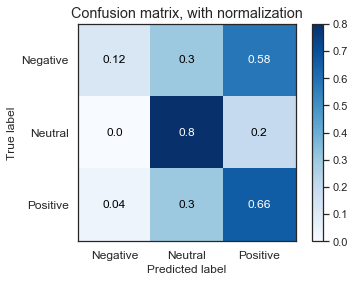

Starting epoch 11
Epoch: 11/30... Step: 10... Loss: 0.620298... Val Loss: 0.708164 Accuracy: 0.703125 F1 Score: 0.540823
Epoch: 11/30... Step: 20... Loss: 0.520917... Val Loss: 0.730219 Accuracy: 0.695913 F1 Score: 0.555704
Epoch: 11/30... Step: 30... Loss: 0.410380... Val Loss: 0.732243 Accuracy: 0.680288 F1 Score: 0.575891
Epoch: 11/30... Step: 40... Loss: 0.600809... Val Loss: 0.714698 Accuracy: 0.697115 F1 Score: 0.564833
Epoch: 11/30... Step: 50... Loss: 0.533820... Val Loss: 0.731601 Accuracy: 0.692308 F1 Score: 0.598942
Epoch: 11/30... Step: 60... Loss: 0.586069... Val Loss: 0.738229 Accuracy: 0.695913 F1 Score: 0.540554
Epoch: 11/30... Step: 70... Loss: 0.570292... Val Loss: 0.717487 Accuracy: 0.689904 F1 Score: 0.581263
Epoch: 11/30... Step: 80... Loss: 0.607002... Val Loss: 0.713230 Accuracy: 0.694712 F1 Score: 0.563352
Epoch: 11/30... Step: 90... Loss: 0.698530... Val Loss: 0.708293 Accuracy: 0.705529 F1 Score: 0.568423
Epoch: 11/30... Step: 100... Loss: 0.522831... Val Loss

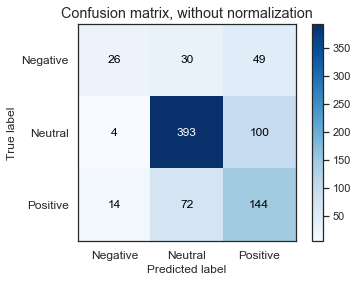

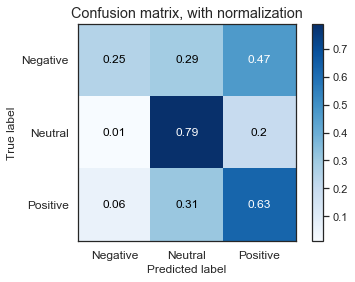

Starting epoch 12
Epoch: 12/30... Step: 10... Loss: 0.619574... Val Loss: 0.712273 Accuracy: 0.705529 F1 Score: 0.562037
Epoch: 12/30... Step: 20... Loss: 0.477080... Val Loss: 0.727519 Accuracy: 0.693510 F1 Score: 0.555012
Epoch: 12/30... Step: 30... Loss: 0.375946... Val Loss: 0.737225 Accuracy: 0.676683 F1 Score: 0.582316
Epoch: 12/30... Step: 40... Loss: 0.580338... Val Loss: 0.720722 Accuracy: 0.700721 F1 Score: 0.573281
Epoch: 12/30... Step: 50... Loss: 0.519548... Val Loss: 0.733433 Accuracy: 0.681490 F1 Score: 0.588993
Epoch: 12/30... Step: 60... Loss: 0.538849... Val Loss: 0.755575 Accuracy: 0.699519 F1 Score: 0.551922
Epoch: 12/30... Step: 70... Loss: 0.513428... Val Loss: 0.723792 Accuracy: 0.688702 F1 Score: 0.593315
Epoch: 12/30... Step: 80... Loss: 0.561785... Val Loss: 0.719892 Accuracy: 0.695913 F1 Score: 0.571868
Epoch: 12/30... Step: 90... Loss: 0.691401... Val Loss: 0.713396 Accuracy: 0.712740 F1 Score: 0.581210
Epoch: 12/30... Step: 100... Loss: 0.456969... Val Loss

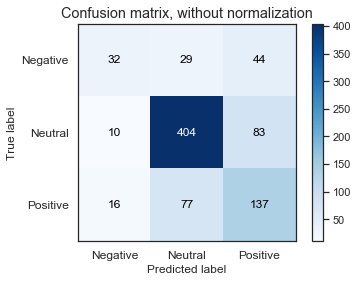

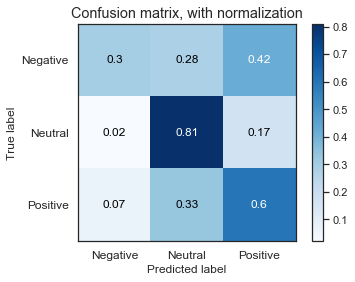

Starting epoch 13
Epoch: 13/30... Step: 10... Loss: 0.593661... Val Loss: 0.719379 Accuracy: 0.711538 F1 Score: 0.578774
Epoch: 13/30... Step: 20... Loss: 0.437287... Val Loss: 0.723065 Accuracy: 0.699519 F1 Score: 0.574958
Epoch: 13/30... Step: 30... Loss: 0.314683... Val Loss: 0.746246 Accuracy: 0.680288 F1 Score: 0.590416
Epoch: 13/30... Step: 40... Loss: 0.531986... Val Loss: 0.729035 Accuracy: 0.709135 F1 Score: 0.596860
Epoch: 13/30... Step: 50... Loss: 0.455250... Val Loss: 0.748513 Accuracy: 0.679087 F1 Score: 0.597750
Epoch: 13/30... Step: 60... Loss: 0.520942... Val Loss: 0.752515 Accuracy: 0.704327 F1 Score: 0.578022
Epoch: 13/30... Step: 70... Loss: 0.508955... Val Loss: 0.727932 Accuracy: 0.688702 F1 Score: 0.591296
Epoch: 13/30... Step: 80... Loss: 0.531010... Val Loss: 0.724704 Accuracy: 0.698317 F1 Score: 0.587810
Epoch: 13/30... Step: 90... Loss: 0.640897... Val Loss: 0.734491 Accuracy: 0.712740 F1 Score: 0.579643
Epoch: 13/30... Step: 100... Loss: 0.451815... Val Loss

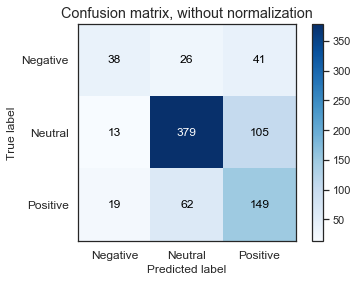

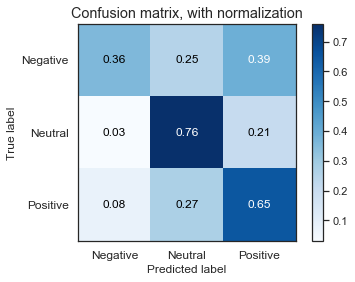

Starting epoch 14
Epoch: 14/30... Step: 10... Loss: 0.544353... Val Loss: 0.739414 Accuracy: 0.707933 F1 Score: 0.581097
Epoch: 14/30... Step: 20... Loss: 0.397653... Val Loss: 0.730037 Accuracy: 0.703125 F1 Score: 0.586790
Epoch: 14/30... Step: 30... Loss: 0.337465... Val Loss: 0.747220 Accuracy: 0.694712 F1 Score: 0.606578
Epoch: 14/30... Step: 40... Loss: 0.489790... Val Loss: 0.747611 Accuracy: 0.706731 F1 Score: 0.589172
Epoch: 14/30... Step: 50... Loss: 0.421802... Val Loss: 0.759004 Accuracy: 0.680288 F1 Score: 0.602422
Epoch: 14/30... Step: 60... Loss: 0.524739... Val Loss: 0.777578 Accuracy: 0.704327 F1 Score: 0.576296
Epoch: 14/30... Step: 70... Loss: 0.459571... Val Loss: 0.739879 Accuracy: 0.694712 F1 Score: 0.600080
Epoch: 14/30... Step: 80... Loss: 0.535993... Val Loss: 0.735233 Accuracy: 0.701923 F1 Score: 0.597024
Epoch: 14/30... Step: 90... Loss: 0.595801... Val Loss: 0.734300 Accuracy: 0.711538 F1 Score: 0.588656
Epoch: 14/30... Step: 100... Loss: 0.418834... Val Loss

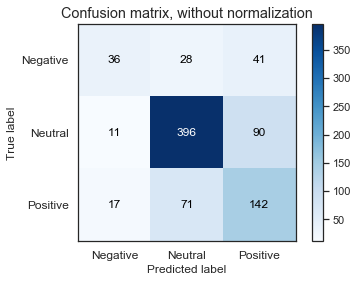

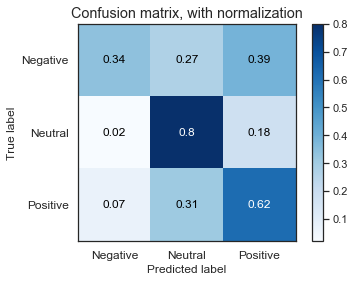

Starting epoch 15
Epoch: 15/30... Step: 10... Loss: 0.562275... Val Loss: 0.757001 Accuracy: 0.710337 F1 Score: 0.589337
Epoch: 15/30... Step: 20... Loss: 0.374790... Val Loss: 0.738018 Accuracy: 0.705529 F1 Score: 0.595251
Epoch: 15/30... Step: 30... Loss: 0.291994... Val Loss: 0.756854 Accuracy: 0.695913 F1 Score: 0.614491
Epoch: 15/30... Step: 40... Loss: 0.448661... Val Loss: 0.765215 Accuracy: 0.704327 F1 Score: 0.595622
Epoch: 15/30... Step: 50... Loss: 0.420273... Val Loss: 0.777913 Accuracy: 0.683894 F1 Score: 0.605293
Epoch: 15/30... Step: 60... Loss: 0.463244... Val Loss: 0.800292 Accuracy: 0.703125 F1 Score: 0.578521
Epoch: 15/30... Step: 70... Loss: 0.502868... Val Loss: 0.789603 Accuracy: 0.682692 F1 Score: 0.614306
Epoch: 15/30... Step: 80... Loss: 0.498964... Val Loss: 0.742723 Accuracy: 0.706731 F1 Score: 0.602081
Epoch: 15/30... Step: 90... Loss: 0.563619... Val Loss: 0.746067 Accuracy: 0.713942 F1 Score: 0.591201
Epoch: 15/30... Step: 100... Loss: 0.386920... Val Loss

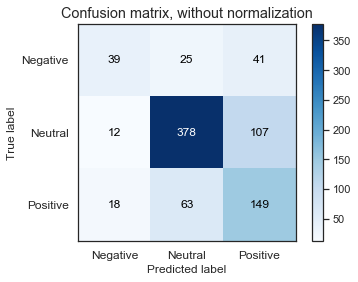

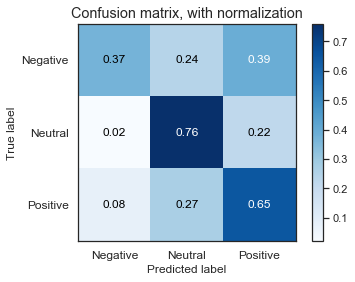

Starting epoch 16
Epoch: 16/30... Step: 10... Loss: 0.479726... Val Loss: 0.768073 Accuracy: 0.713942 F1 Score: 0.594527
Epoch: 16/30... Step: 20... Loss: 0.359406... Val Loss: 0.749393 Accuracy: 0.710337 F1 Score: 0.608729
Epoch: 16/30... Step: 30... Loss: 0.234128... Val Loss: 0.764416 Accuracy: 0.693510 F1 Score: 0.616126
Epoch: 16/30... Step: 40... Loss: 0.444949... Val Loss: 0.789678 Accuracy: 0.705529 F1 Score: 0.593561
Epoch: 16/30... Step: 50... Loss: 0.383479... Val Loss: 0.806091 Accuracy: 0.671875 F1 Score: 0.596549
Epoch: 16/30... Step: 60... Loss: 0.384830... Val Loss: 0.799133 Accuracy: 0.711538 F1 Score: 0.603282
Epoch: 16/30... Step: 70... Loss: 0.424531... Val Loss: 0.799256 Accuracy: 0.705529 F1 Score: 0.622387
Epoch: 16/30... Step: 80... Loss: 0.481452... Val Loss: 0.763677 Accuracy: 0.710337 F1 Score: 0.615803
Epoch: 16/30... Step: 90... Loss: 0.566395... Val Loss: 0.759125 Accuracy: 0.707933 F1 Score: 0.615270
Epoch: 16/30... Step: 100... Loss: 0.330060... Val Loss

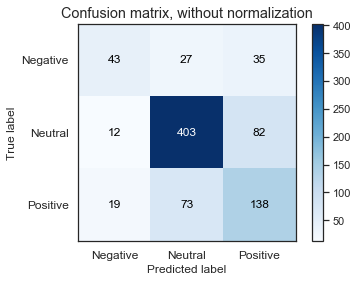

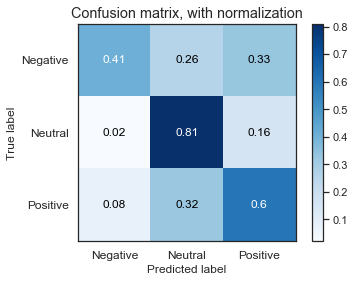

Starting epoch 17
Epoch: 17/30... Step: 10... Loss: 0.511192... Val Loss: 0.792927 Accuracy: 0.713942 F1 Score: 0.592750
Epoch: 17/30... Step: 20... Loss: 0.328942... Val Loss: 0.755778 Accuracy: 0.717548 F1 Score: 0.621501
Epoch: 17/30... Step: 30... Loss: 0.231250... Val Loss: 0.767503 Accuracy: 0.704327 F1 Score: 0.621715
Epoch: 17/30... Step: 40... Loss: 0.385263... Val Loss: 0.810981 Accuracy: 0.709135 F1 Score: 0.618655
Epoch: 17/30... Step: 50... Loss: 0.356354... Val Loss: 0.828455 Accuracy: 0.686298 F1 Score: 0.606785
Epoch: 17/30... Step: 60... Loss: 0.326212... Val Loss: 0.827127 Accuracy: 0.709135 F1 Score: 0.598007
Epoch: 17/30... Step: 70... Loss: 0.435101... Val Loss: 0.853240 Accuracy: 0.685096 F1 Score: 0.611254
Epoch: 17/30... Step: 80... Loss: 0.516923... Val Loss: 0.800734 Accuracy: 0.715144 F1 Score: 0.617293
Epoch: 17/30... Step: 90... Loss: 0.564587... Val Loss: 0.782668 Accuracy: 0.713942 F1 Score: 0.619639
Epoch: 17/30... Step: 100... Loss: 0.329509... Val Loss

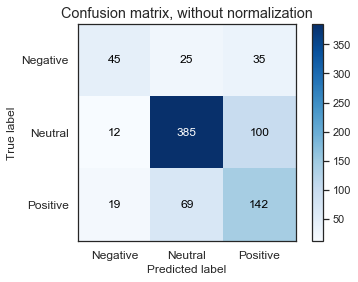

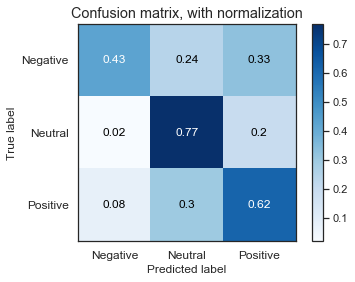

Starting epoch 18
Epoch: 18/30... Step: 10... Loss: 0.457673... Val Loss: 0.828165 Accuracy: 0.713942 F1 Score: 0.593857
Epoch: 18/30... Step: 20... Loss: 0.305651... Val Loss: 0.776450 Accuracy: 0.700721 F1 Score: 0.612732
Epoch: 18/30... Step: 30... Loss: 0.239187... Val Loss: 0.797529 Accuracy: 0.704327 F1 Score: 0.621554
Epoch: 18/30... Step: 40... Loss: 0.327992... Val Loss: 0.836677 Accuracy: 0.705529 F1 Score: 0.612685
Epoch: 18/30... Step: 50... Loss: 0.301324... Val Loss: 0.867391 Accuracy: 0.676683 F1 Score: 0.603950
Epoch: 18/30... Step: 60... Loss: 0.307147... Val Loss: 0.824312 Accuracy: 0.717548 F1 Score: 0.622016
Epoch: 18/30... Step: 70... Loss: 0.370637... Val Loss: 0.876721 Accuracy: 0.691106 F1 Score: 0.617335
Epoch: 18/30... Step: 80... Loss: 0.518553... Val Loss: 0.826579 Accuracy: 0.715144 F1 Score: 0.616458
Epoch: 18/30... Step: 90... Loss: 0.533821... Val Loss: 0.799699 Accuracy: 0.718750 F1 Score: 0.625552
Epoch: 18/30... Step: 100... Loss: 0.268291... Val Loss

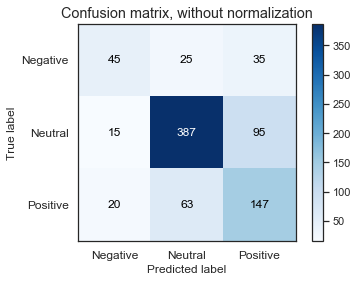

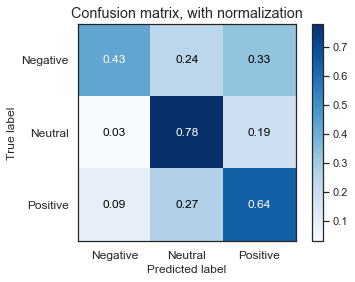

Starting epoch 19
Epoch: 19/30... Step: 10... Loss: 0.455598... Val Loss: 0.845824 Accuracy: 0.710337 F1 Score: 0.598347
Epoch: 19/30... Step: 20... Loss: 0.293699... Val Loss: 0.796658 Accuracy: 0.704327 F1 Score: 0.608693
Epoch: 19/30... Step: 30... Loss: 0.265530... Val Loss: 0.825229 Accuracy: 0.698317 F1 Score: 0.612903
Epoch: 19/30... Step: 40... Loss: 0.283348... Val Loss: 0.895612 Accuracy: 0.694712 F1 Score: 0.617114
Epoch: 19/30... Step: 50... Loss: 0.279543... Val Loss: 0.861009 Accuracy: 0.692308 F1 Score: 0.606333
Epoch: 19/30... Step: 60... Loss: 0.368147... Val Loss: 0.842407 Accuracy: 0.707933 F1 Score: 0.615594
Epoch: 19/30... Step: 70... Loss: 0.346506... Val Loss: 0.883182 Accuracy: 0.681490 F1 Score: 0.603087
Epoch: 19/30... Step: 80... Loss: 0.515314... Val Loss: 0.832188 Accuracy: 0.722356 F1 Score: 0.623266
Epoch: 19/30... Step: 90... Loss: 0.499569... Val Loss: 0.801704 Accuracy: 0.695913 F1 Score: 0.618449
Epoch: 19/30... Step: 100... Loss: 0.260123... Val Loss

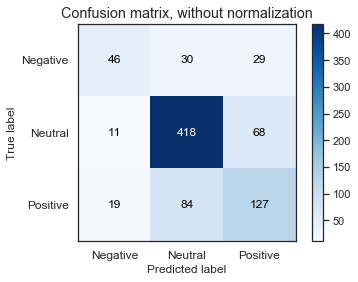

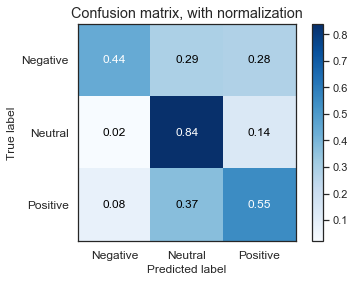

Starting epoch 20
Epoch: 20/30... Step: 10... Loss: 0.403959... Val Loss: 0.881401 Accuracy: 0.728365 F1 Score: 0.614192
Epoch: 20/30... Step: 20... Loss: 0.366662... Val Loss: 0.820493 Accuracy: 0.682692 F1 Score: 0.607160
Epoch: 20/30... Step: 30... Loss: 0.216458... Val Loss: 0.813778 Accuracy: 0.706731 F1 Score: 0.619388
Epoch: 20/30... Step: 40... Loss: 0.275753... Val Loss: 0.869555 Accuracy: 0.712740 F1 Score: 0.621722
Epoch: 20/30... Step: 50... Loss: 0.263620... Val Loss: 0.893705 Accuracy: 0.689904 F1 Score: 0.610200
Epoch: 20/30... Step: 60... Loss: 0.311510... Val Loss: 0.851830 Accuracy: 0.705529 F1 Score: 0.612092
Epoch: 20/30... Step: 70... Loss: 0.344338... Val Loss: 0.873442 Accuracy: 0.700721 F1 Score: 0.616317
Epoch: 20/30... Step: 80... Loss: 0.477512... Val Loss: 0.855251 Accuracy: 0.723558 F1 Score: 0.621858
Epoch: 20/30... Step: 90... Loss: 0.429890... Val Loss: 0.833115 Accuracy: 0.694712 F1 Score: 0.615812
Epoch: 20/30... Step: 100... Loss: 0.225173... Val Loss

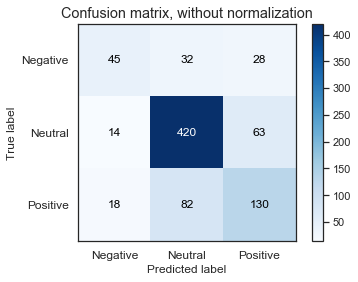

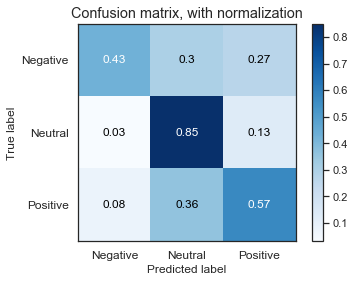

Starting epoch 21
Epoch: 21/30... Step: 10... Loss: 0.373541... Val Loss: 0.910048 Accuracy: 0.718750 F1 Score: 0.603244
Epoch: 21/30... Step: 20... Loss: 0.281916... Val Loss: 0.832850 Accuracy: 0.692308 F1 Score: 0.617771
Epoch: 21/30... Step: 30... Loss: 0.282993... Val Loss: 0.844174 Accuracy: 0.721154 F1 Score: 0.624956
Epoch: 21/30... Step: 40... Loss: 0.292798... Val Loss: 0.919548 Accuracy: 0.698317 F1 Score: 0.619343
Epoch: 21/30... Step: 50... Loss: 0.214381... Val Loss: 0.903579 Accuracy: 0.698317 F1 Score: 0.614506
Epoch: 21/30... Step: 60... Loss: 0.394227... Val Loss: 0.895173 Accuracy: 0.692308 F1 Score: 0.608266
Epoch: 21/30... Step: 70... Loss: 0.337953... Val Loss: 0.882780 Accuracy: 0.706731 F1 Score: 0.618631
Epoch: 21/30... Step: 80... Loss: 0.476033... Val Loss: 0.870727 Accuracy: 0.709135 F1 Score: 0.626961
Epoch: 21/30... Step: 90... Loss: 0.443908... Val Loss: 0.823394 Accuracy: 0.701923 F1 Score: 0.623482
Epoch: 21/30... Step: 100... Loss: 0.212273... Val Loss

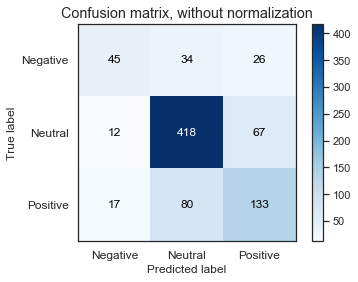

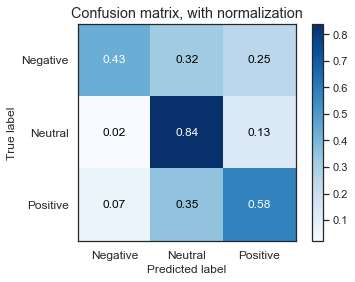

Starting epoch 22
Epoch: 22/30... Step: 10... Loss: 0.458505... Val Loss: 0.906680 Accuracy: 0.722356 F1 Score: 0.611640
Epoch: 22/30... Step: 20... Loss: 0.224971... Val Loss: 0.845061 Accuracy: 0.685096 F1 Score: 0.601221
Epoch: 22/30... Step: 30... Loss: 0.200314... Val Loss: 0.863634 Accuracy: 0.710337 F1 Score: 0.623274
Epoch: 22/30... Step: 40... Loss: 0.270848... Val Loss: 0.917816 Accuracy: 0.704327 F1 Score: 0.622662
Epoch: 22/30... Step: 50... Loss: 0.182195... Val Loss: 0.948061 Accuracy: 0.687500 F1 Score: 0.611388
Epoch: 22/30... Step: 60... Loss: 0.267776... Val Loss: 0.927520 Accuracy: 0.701923 F1 Score: 0.613230
Epoch: 22/30... Step: 70... Loss: 0.292791... Val Loss: 0.919589 Accuracy: 0.713942 F1 Score: 0.625979
Epoch: 22/30... Step: 80... Loss: 0.504804... Val Loss: 0.945975 Accuracy: 0.686298 F1 Score: 0.614217
Epoch: 22/30... Step: 90... Loss: 0.466073... Val Loss: 0.869306 Accuracy: 0.719952 F1 Score: 0.632041
Epoch: 22/30... Step: 100... Loss: 0.184487... Val Loss

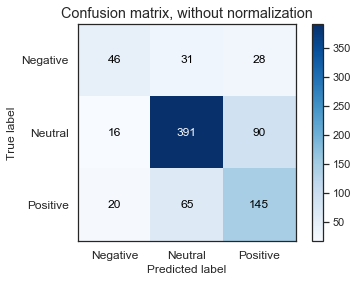

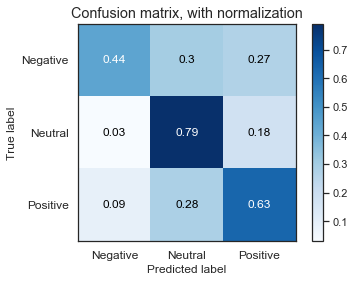

Starting epoch 23
Epoch: 23/30... Step: 10... Loss: 0.393434... Val Loss: 0.934242 Accuracy: 0.725962 F1 Score: 0.625985
Epoch: 23/30... Step: 20... Loss: 0.223995... Val Loss: 0.858741 Accuracy: 0.691106 F1 Score: 0.610425
Epoch: 23/30... Step: 30... Loss: 0.216702... Val Loss: 0.878571 Accuracy: 0.707933 F1 Score: 0.620188
Epoch: 23/30... Step: 40... Loss: 0.265182... Val Loss: 0.995392 Accuracy: 0.691106 F1 Score: 0.612582
Epoch: 23/30... Step: 50... Loss: 0.212771... Val Loss: 0.940858 Accuracy: 0.701923 F1 Score: 0.616771
Epoch: 23/30... Step: 60... Loss: 0.264059... Val Loss: 0.958760 Accuracy: 0.699519 F1 Score: 0.620572
Epoch: 23/30... Step: 70... Loss: 0.297389... Val Loss: 0.941033 Accuracy: 0.710337 F1 Score: 0.617674
Epoch: 23/30... Step: 80... Loss: 0.486318... Val Loss: 0.932103 Accuracy: 0.707933 F1 Score: 0.628291
Epoch: 23/30... Step: 90... Loss: 0.392941... Val Loss: 0.884703 Accuracy: 0.716346 F1 Score: 0.627851
Epoch: 23/30... Step: 100... Loss: 0.212499... Val Loss

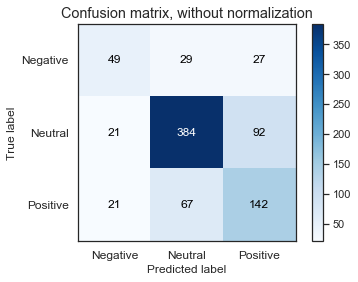

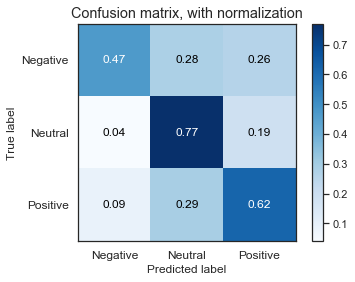

Starting epoch 24
Epoch: 24/30... Step: 10... Loss: 0.377312... Val Loss: 0.947754 Accuracy: 0.719952 F1 Score: 0.622849
Epoch: 24/30... Step: 20... Loss: 0.197209... Val Loss: 0.883709 Accuracy: 0.703125 F1 Score: 0.624852
Epoch: 24/30... Step: 30... Loss: 0.222302... Val Loss: 0.916206 Accuracy: 0.697115 F1 Score: 0.620086
Epoch: 24/30... Step: 40... Loss: 0.271985... Val Loss: 0.964944 Accuracy: 0.710337 F1 Score: 0.629774
Epoch: 24/30... Step: 50... Loss: 0.228498... Val Loss: 0.980737 Accuracy: 0.689904 F1 Score: 0.611435
Epoch: 24/30... Step: 60... Loss: 0.232251... Val Loss: 0.982923 Accuracy: 0.703125 F1 Score: 0.617159
Epoch: 24/30... Step: 70... Loss: 0.341204... Val Loss: 0.982003 Accuracy: 0.711538 F1 Score: 0.621175
Epoch: 24/30... Step: 80... Loss: 0.452608... Val Loss: 1.015026 Accuracy: 0.685096 F1 Score: 0.614311
Epoch: 24/30... Step: 90... Loss: 0.392578... Val Loss: 0.962523 Accuracy: 0.721154 F1 Score: 0.625979
Epoch: 24/30... Step: 100... Loss: 0.182487... Val Loss

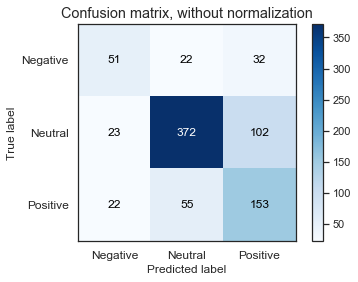

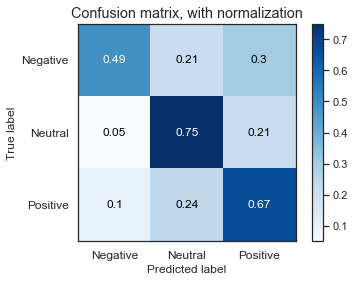

Starting epoch 25
Epoch: 25/30... Step: 10... Loss: 0.378428... Val Loss: 0.999480 Accuracy: 0.722356 F1 Score: 0.627576
Epoch: 25/30... Step: 20... Loss: 0.197758... Val Loss: 0.924428 Accuracy: 0.685096 F1 Score: 0.605269
Epoch: 25/30... Step: 30... Loss: 0.180703... Val Loss: 0.947859 Accuracy: 0.698317 F1 Score: 0.623313
Epoch: 25/30... Step: 40... Loss: 0.214091... Val Loss: 1.027959 Accuracy: 0.704327 F1 Score: 0.619225
Epoch: 25/30... Step: 50... Loss: 0.211735... Val Loss: 1.035347 Accuracy: 0.694712 F1 Score: 0.619682
Epoch: 25/30... Step: 60... Loss: 0.217581... Val Loss: 1.027161 Accuracy: 0.710337 F1 Score: 0.620367
Epoch: 25/30... Step: 70... Loss: 0.289795... Val Loss: 1.022303 Accuracy: 0.703125 F1 Score: 0.617210
Epoch: 25/30... Step: 80... Loss: 0.458721... Val Loss: 1.072799 Accuracy: 0.689904 F1 Score: 0.618254
Epoch: 25/30... Step: 90... Loss: 0.346027... Val Loss: 0.993046 Accuracy: 0.711538 F1 Score: 0.616719
Epoch: 25/30... Step: 100... Loss: 0.133792... Val Loss

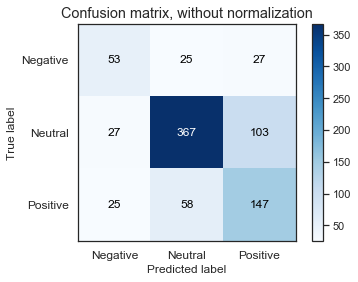

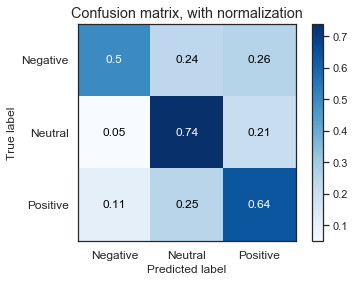

Starting epoch 26
Epoch: 26/30... Step: 10... Loss: 0.328888... Val Loss: 1.067961 Accuracy: 0.718750 F1 Score: 0.623756
Epoch: 26/30... Step: 20... Loss: 0.234356... Val Loss: 0.970559 Accuracy: 0.682692 F1 Score: 0.610832
Epoch: 26/30... Step: 30... Loss: 0.180286... Val Loss: 0.993468 Accuracy: 0.688702 F1 Score: 0.616935
Epoch: 26/30... Step: 40... Loss: 0.207612... Val Loss: 1.042110 Accuracy: 0.707933 F1 Score: 0.626106
Epoch: 26/30... Step: 50... Loss: 0.194514... Val Loss: 1.074495 Accuracy: 0.687500 F1 Score: 0.621549
Epoch: 26/30... Step: 60... Loss: 0.151062... Val Loss: 1.061345 Accuracy: 0.705529 F1 Score: 0.615127
Epoch: 26/30... Step: 70... Loss: 0.323767... Val Loss: 1.066142 Accuracy: 0.705529 F1 Score: 0.617903
Epoch: 26/30... Step: 80... Loss: 0.376386... Val Loss: 1.078561 Accuracy: 0.695913 F1 Score: 0.625673
Epoch: 26/30... Step: 90... Loss: 0.341822... Val Loss: 1.071401 Accuracy: 0.712740 F1 Score: 0.619724
Epoch: 26/30... Step: 100... Loss: 0.137424... Val Loss

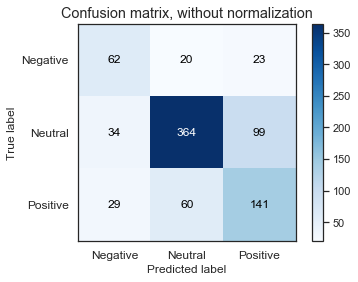

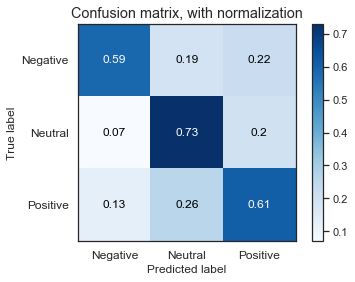

Starting epoch 27
Epoch: 27/30... Step: 10... Loss: 0.367649... Val Loss: 1.133067 Accuracy: 0.712740 F1 Score: 0.601163
Epoch: 27/30... Step: 20... Loss: 0.162869... Val Loss: 0.986194 Accuracy: 0.695913 F1 Score: 0.623493
Epoch: 27/30... Step: 30... Loss: 0.221880... Val Loss: 1.004918 Accuracy: 0.705529 F1 Score: 0.636378
Epoch: 27/30... Step: 40... Loss: 0.243079... Val Loss: 1.089273 Accuracy: 0.710337 F1 Score: 0.629054
Epoch: 27/30... Step: 50... Loss: 0.186005... Val Loss: 1.115963 Accuracy: 0.692308 F1 Score: 0.624466
Epoch: 27/30... Step: 60... Loss: 0.142796... Val Loss: 1.088499 Accuracy: 0.707933 F1 Score: 0.618518
Epoch: 27/30... Step: 70... Loss: 0.306041... Val Loss: 1.095896 Accuracy: 0.711538 F1 Score: 0.622945
Epoch: 27/30... Step: 80... Loss: 0.318850... Val Loss: 1.127826 Accuracy: 0.686298 F1 Score: 0.623724
Epoch: 27/30... Step: 90... Loss: 0.292003... Val Loss: 1.116189 Accuracy: 0.710337 F1 Score: 0.616547
Epoch: 27/30... Step: 100... Loss: 0.109636... Val Loss

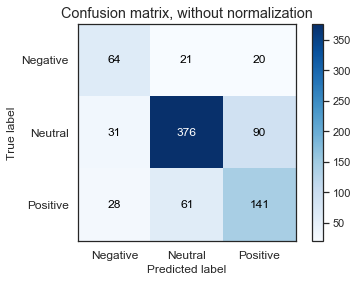

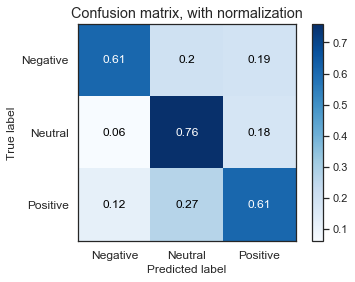

Starting epoch 28
Epoch: 28/30... Step: 10... Loss: 0.293334... Val Loss: 1.192059 Accuracy: 0.719952 F1 Score: 0.608374
Epoch: 28/30... Step: 20... Loss: 0.192833... Val Loss: 1.019340 Accuracy: 0.704327 F1 Score: 0.638809
Epoch: 28/30... Step: 30... Loss: 0.293979... Val Loss: 1.022460 Accuracy: 0.701923 F1 Score: 0.634932
Epoch: 28/30... Step: 40... Loss: 0.176660... Val Loss: 1.117427 Accuracy: 0.711538 F1 Score: 0.620577
Epoch: 28/30... Step: 50... Loss: 0.213780... Val Loss: 1.144536 Accuracy: 0.700721 F1 Score: 0.635052
Epoch: 28/30... Step: 60... Loss: 0.140269... Val Loss: 1.070140 Accuracy: 0.703125 F1 Score: 0.618661
Epoch: 28/30... Step: 70... Loss: 0.309446... Val Loss: 1.142419 Accuracy: 0.717548 F1 Score: 0.630405
Epoch: 28/30... Step: 80... Loss: 0.309353... Val Loss: 1.192332 Accuracy: 0.681490 F1 Score: 0.623868
Epoch: 28/30... Step: 90... Loss: 0.285934... Val Loss: 1.129518 Accuracy: 0.713942 F1 Score: 0.615952
Epoch: 28/30... Step: 100... Loss: 0.113773... Val Loss

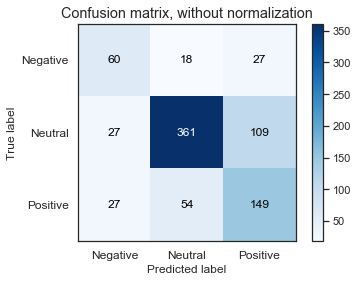

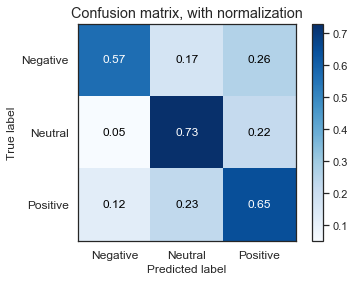

Starting epoch 29
Epoch: 29/30... Step: 10... Loss: 0.324336... Val Loss: 1.164409 Accuracy: 0.722356 F1 Score: 0.614149
Epoch: 29/30... Step: 20... Loss: 0.124830... Val Loss: 1.031953 Accuracy: 0.703125 F1 Score: 0.628974
Epoch: 29/30... Step: 30... Loss: 0.209200... Val Loss: 1.053480 Accuracy: 0.703125 F1 Score: 0.632243
Epoch: 29/30... Step: 40... Loss: 0.197267... Val Loss: 1.140510 Accuracy: 0.721154 F1 Score: 0.637598
Epoch: 29/30... Step: 50... Loss: 0.191958... Val Loss: 1.151268 Accuracy: 0.706731 F1 Score: 0.638882
Epoch: 29/30... Step: 60... Loss: 0.115392... Val Loss: 1.104769 Accuracy: 0.711538 F1 Score: 0.623526
Epoch: 29/30... Step: 70... Loss: 0.294292... Val Loss: 1.131381 Accuracy: 0.716346 F1 Score: 0.632255
Epoch: 29/30... Step: 80... Loss: 0.351853... Val Loss: 1.193245 Accuracy: 0.694712 F1 Score: 0.633689
Epoch: 29/30... Step: 90... Loss: 0.322522... Val Loss: 1.181758 Accuracy: 0.709135 F1 Score: 0.611064
Epoch: 29/30... Step: 100... Loss: 0.121215... Val Loss

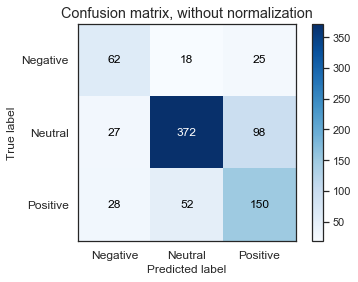

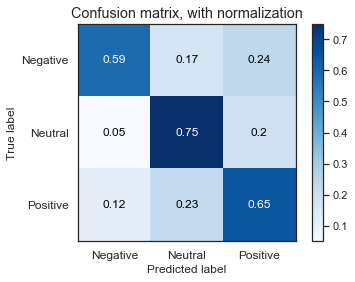

Starting epoch 30
Epoch: 30/30... Step: 10... Loss: 0.321361... Val Loss: 1.230946 Accuracy: 0.716346 F1 Score: 0.606474
Epoch: 30/30... Step: 20... Loss: 0.106416... Val Loss: 1.073229 Accuracy: 0.701923 F1 Score: 0.640062
Epoch: 30/30... Step: 30... Loss: 0.200355... Val Loss: 1.070248 Accuracy: 0.706731 F1 Score: 0.636830
Epoch: 30/30... Step: 40... Loss: 0.180411... Val Loss: 1.183209 Accuracy: 0.724760 F1 Score: 0.635644
Epoch: 30/30... Step: 50... Loss: 0.190086... Val Loss: 1.184894 Accuracy: 0.704327 F1 Score: 0.629899
Epoch: 30/30... Step: 60... Loss: 0.094395... Val Loss: 1.127840 Accuracy: 0.712740 F1 Score: 0.634523
Epoch: 30/30... Step: 70... Loss: 0.331434... Val Loss: 1.194557 Accuracy: 0.719952 F1 Score: 0.634088
Epoch: 30/30... Step: 80... Loss: 0.298122... Val Loss: 1.217885 Accuracy: 0.693510 F1 Score: 0.637674
Epoch: 30/30... Step: 90... Loss: 0.161989... Val Loss: 1.243938 Accuracy: 0.716346 F1 Score: 0.617724
Epoch: 30/30... Step: 100... Loss: 0.096827... Val Loss

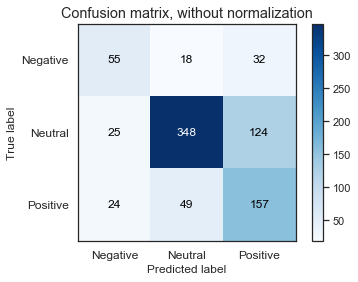

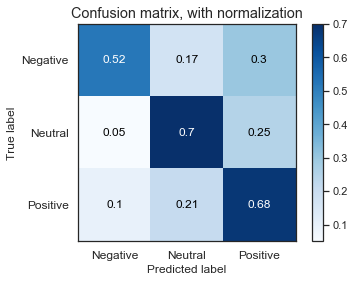

In [239]:
train_model(model)

## E. BERT Model

In [240]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
#import torch


In [241]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

In [242]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=80):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [248]:
# Prepare training data
train_set = []
max_seq_length = 80

for index, row in tqdm(train_tone_df.iterrows(), total=train_tone_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

train_labels = train_tone_df['label'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(train_tone_df), 3), dtype=np.float32)

In [259]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        #self.fc1 = nn.Linear(hidden_size, dense_size)
        #self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fx = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
#         dense_out = self.fc1(self.dropout(feature))
#         # Concatinate the dense output and meta inputs
#         concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
#         out = self.fc2(concat_layer)
        out = self.fc(self.dropout(feature))

        return out

In [260]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple


tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
(tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>), tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9586e-02, -9.9965e-01,
          5.0146e-02,  4.4756e-01,  9.7612e-01,  3.3988e-02,  8.4494e-01,
         -3.6905e-01,  9.8649e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.7372e-01,
   

In [262]:
# Test Tokenizer - Own Implementation
bert_model = BertTextClassifier(768, 3, dropout=0.1)

text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
#print('pad_masks: ',pad_masks)
#print('segment_ids: ',segment_ids)
x_meta = torch.tensor([1,2,3,4,5,6,7,8,9,10]).unsqueeze(0)
outputs = bert_model(text_ids)
print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs.detach())

text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
text_ids (unsqueezed): 
 tensor([[  101,  7592,  1010,  2026,  3899,  20

In [266]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 5
batch_size = 32
patience =2
file_name = 'model'
use_skf = True
bert_hidden_size = 768
bert_dense_size = 128

In [267]:
def train_bert(fold, train_indices, valid_indices):
    
    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
#     bert_model = BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels = 3,
#         output_attentions = False,
#         output_hidden_states = False
#     )

    bert_model = BertTextClassifier(bert_hidden_size, 3, dropout=0.1)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch
            
            # Feedforward prediction
            y_pred = bert_model(x_ids)

            # Calculate Loss
            loss = loss_fn(y_pred, y_truth)
                        
            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)
            
            logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        # Move to Evaluation Mode
        model.eval()
        
        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                y_pred = bert_model(x_ids).detach()
                loss = loss_fn(y_pred, y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                logger.debug('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break
            
        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            y_pred = bert_model(x_ids).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()


    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

In [ ]:
if use_skf:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
    for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
        train_bert(fold, train_indices, valid_indices)

else:
    train_ratio = 0.7
    train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
    valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

    train_bert(0, train_indices, valid_indices)
    # print('train_indices', train_indices)
    # print('valid_indices', valid_indices)


[2020-07-07 19:09:59,590][INFO] ## ================     fold 0        ===============
[2020-07-07 19:10:02,256][INFO] ## ================     epoch 1        ===============


[2020-07-07 19:29:35,867][INFO] ## epoch: 0, train loss: 1.28208005, valid loss: 1.28544915, acc: 0.17437722, f1: 0.17249049, best_f1: 0.17249049

[2020-07-07 19:29:35,885][INFO] ## ================     epoch 2        ===============


In [ ]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
split_train_df['pred_target'] = np.argmax(oof_train, axis=1)
split_train_df['pred_target_lower'] = oof_train[:,0]
split_train_df['pred_target_hold'] = oof_train[:,1]
split_train_df['pred_target_raise'] = oof_train[:,2]
split_train_df.head()

# Save Data

In [127]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [128]:
# Save text data
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')
save_data(train_df, 'split_train_df')